### Generate weights from NN training

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import scipy
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
transform = torchvision.transforms.Compose([
            torchvision.transforms.CenterCrop(21),
            torchvision.transforms.ToTensor(),
            # Apply with Lambda your custom transformation
#             torchvision.transforms.Lambda(lambda x:x/255.0),
        ])

In [3]:
mnist_dev = torchvision.datasets.MNIST("./data", train=True, download=True, transform = transform)
mnist_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform = transform)

In [4]:
n_train = 60000
n_test = len(mnist_dev) - n_train
train_dataset, val_dataset = torch.utils.data.random_split(mnist_dev, [n_train, n_test])

In [5]:
len(train_dataset)

60000

In [6]:
train_dataset[0][0].shape

torch.Size([1, 21, 21])

In [7]:
torch.max(train_dataset[10][0][:,:,:])

tensor(1.)

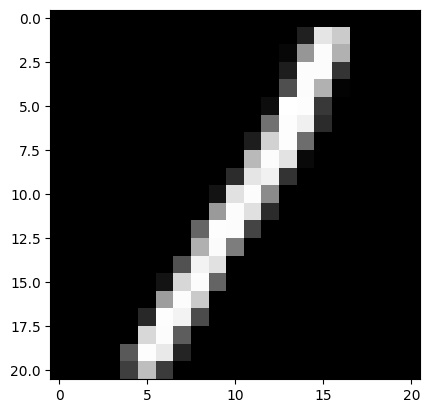

In [8]:
plt.imshow(train_dataset[10][0][0,:,:], cmap="gray")

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
class Net(nn.Module):
    def __init__(self, activation=nn.ReLU(),
                 input_size=1*21*21, hidden_size=7, classes=10):
        
        super(Net, self).__init__()
        self.input_size = input_size

        # Here we initialize our activation and set up our two linear layers
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, classes)

    def forward(self, x):
        x = x.view(-1, self.input_size) # flatten
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return x

    def get_net_params(self):
        param_list = np.array([])
        for params in self.parameters():    
            param_list = np.concatenate((param_list, params.cpu().detach().numpy().flatten()))
        return param_list

In [11]:
net = Net()
net.get_net_params().shape

(3174,)

In [12]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [13]:
len(train_loader)

938

In [15]:
def sample_nn_run(seed, optimizer_choice ="adam"):
    print("seed: ", seed)

    torch.manual_seed(seed)
    
    net = Net()
    # Always remember to move the network to the GPU/CPU depending on device
    net = net.to(device) 
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_choice == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0)
        
    if optimizer_choice == "SGD_mom":
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    if optimizer_choice == "adam":
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        # adam with lr = 0.001
    
    
    print("Optimizer: ", optimizer )
    print("Shapes of the Parameter Matrix:")

    for parameter in net.parameters():
            print(parameter.shape)

    print("weight init shape: ", net.get_net_params().shape)
    print("weight init mean: ", net.get_net_params().mean())
    
    train_loss_history = [] # loss
    train_acc_history = [] # accuracy

    weights = [net.get_net_params()]
    test_weights = []
    train_loss = []
    
    w_update_i = 0
    
    for epoch in range(32):

        running_loss = 0.0
        correct = 0.0
        total = 0

        # Iterating through the minibatches of the data

        for i, data in enumerate(train_loader, 0):
            w_update_i +=1
            # data is a tuple of (inputs, labels)
            X, y = data

            X = X.to(device)
            y = y.to(device)

            # Reset the parameter gradients  for the current  minibatch iteration 
            optimizer.zero_grad()


            y_pred = net(X)             # Perform a forward pass on the network with inputs
            loss = criterion(y_pred, y) # calculate the loss with the network predictions and ground Truth
            loss.backward()             # Perform a backward pass to calculate the gradients
            optimizer.step()            # Optimize the network parameters with calculated gradients
            
            # save weights
            if (w_update_i >= 1000):
                test_weights.append(net.get_net_params())
            else:
                weights.append(net.get_net_params())
                        

            train_loss.append(loss.item())
                    
            # Accumulate the loss and calculate the accuracy of predictions
            running_loss += loss.item()
            _, preds = torch.max(y_pred, 1) #convert output probabilities of each class to a singular class prediction
            correct += preds.eq(y).sum().item()
            total += y.size(0)
        

            # Print statistics to console
            if i % 200 == 99: # print every 100 mini-batches
                running_loss /= 100
                correct /= total
                print("[Epoch %d, Iteration %5d] loss: %.3f acc: %.2f %%" % (epoch+1, i+1, running_loss, 100*correct))
                train_loss_history.append(running_loss)
                train_acc_history.append(correct)
                running_loss = 0.0
                correct = 0.0
                total = 0
        
#         train_loss.append(running_loss/len(train_loader))
    
    return weights, test_weights, train_loss

In [16]:
w_adam, test_w_adam, train_loss_adam  = sample_nn_run(12, optimizer_choice = "adam")

seed:  12
Optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Shapes of the Parameter Matrix:
torch.Size([7, 441])
torch.Size([7])
torch.Size([10, 7])
torch.Size([10])
weight init shape:  (3174,)
weight init mean:  0.0002916963511600236
[Epoch 1, Iteration   100] loss: 1.963 acc: 30.59 %
[Epoch 1, Iteration   300] loss: 2.306 acc: 67.09 %
[Epoch 1, Iteration   500] loss: 1.439 acc: 80.19 %
[Epoch 1, Iteration   700] loss: 1.160 acc: 83.77 %
[Epoch 1, Iteration   900] loss: 1.024 acc: 85.65 %
[Epoch 2, Iteration   100] loss: 0.487 acc: 86.05 %
[Epoch 2, Iteration   300] loss: 0.934 acc: 87.05 %
[Epoch 2, Iteration   500] loss: 0.864 acc: 87.54 %
[Epoch 2, Iteration   700] loss: 0.870 acc: 87.99 %
[Epoch 2, Iteration   900] loss: 0.834 acc: 88.34 %
[Epoch 3, Iteration   100] loss: 0.421 acc: 88.25 %
[Epoch 3,

[Epoch 30, Iteration   700] loss: 0.603 acc: 91.59 %
[Epoch 30, Iteration   900] loss: 0.621 acc: 91.48 %
[Epoch 31, Iteration   100] loss: 0.292 acc: 91.70 %
[Epoch 31, Iteration   300] loss: 0.610 acc: 91.61 %
[Epoch 31, Iteration   500] loss: 0.586 acc: 91.45 %
[Epoch 31, Iteration   700] loss: 0.608 acc: 91.49 %
[Epoch 31, Iteration   900] loss: 0.589 acc: 91.50 %
[Epoch 32, Iteration   100] loss: 0.302 acc: 91.28 %
[Epoch 32, Iteration   300] loss: 0.585 acc: 91.68 %
[Epoch 32, Iteration   500] loss: 0.600 acc: 91.27 %
[Epoch 32, Iteration   700] loss: 0.597 acc: 91.95 %
[Epoch 32, Iteration   900] loss: 0.594 acc: 91.74 %


In [17]:
w_sgd_mom, test_w_sgd_mom, train_loss_sgd_mom  = sample_nn_run(12, optimizer_choice = "SGD_mom")

seed:  12
Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Shapes of the Parameter Matrix:
torch.Size([7, 441])
torch.Size([7])
torch.Size([10, 7])
torch.Size([10])
weight init shape:  (3174,)
weight init mean:  0.0002916963511600236
[Epoch 1, Iteration   100] loss: 2.276 acc: 19.23 %
[Epoch 1, Iteration   300] loss: 4.209 acc: 28.75 %
[Epoch 1, Iteration   500] loss: 3.523 acc: 40.57 %
[Epoch 1, Iteration   700] loss: 2.713 acc: 64.48 %
[Epoch 1, Iteration   900] loss: 2.100 acc: 73.59 %
[Epoch 2, Iteration   100] loss: 0.869 acc: 76.80 %
[Epoch 2, Iteration   300] loss: 1.534 acc: 79.02 %
[Epoch 2, Iteration   500] loss: 1.336 acc: 81.28 %
[Epoch 2, Iteration   700] loss: 1.243 acc: 83.06 %
[Epoch 2, Iteration   900] loss: 1.159 acc: 83.88 %
[Epoch 3, Iteration   100] loss: 0.543 acc: 84.83 %
[Epoch 3, Iteration   300] loss: 1.056 acc: 85.36 %


[Epoch 30, Iteration   900] loss: 0.617 acc: 91.52 %
[Epoch 31, Iteration   100] loss: 0.297 acc: 91.91 %
[Epoch 31, Iteration   300] loss: 0.611 acc: 91.50 %
[Epoch 31, Iteration   500] loss: 0.600 acc: 91.45 %
[Epoch 31, Iteration   700] loss: 0.612 acc: 91.62 %
[Epoch 31, Iteration   900] loss: 0.601 acc: 91.37 %
[Epoch 32, Iteration   100] loss: 0.307 acc: 91.70 %
[Epoch 32, Iteration   300] loss: 0.598 acc: 91.65 %
[Epoch 32, Iteration   500] loss: 0.602 acc: 91.34 %
[Epoch 32, Iteration   700] loss: 0.598 acc: 91.67 %
[Epoch 32, Iteration   900] loss: 0.602 acc: 91.88 %


In [ ]:
w_sgd, test_w_sgd, train_loss_sgd  = sample_nn_run(12, optimizer_choice = "SGD")

seed:  12
Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Shapes of the Parameter Matrix:
torch.Size([7, 441])
torch.Size([7])
torch.Size([10, 7])
torch.Size([10])
weight init shape:  (3174,)
weight init mean:  0.0002916963511600236
[Epoch 1, Iteration   100] loss: 2.316 acc: 17.44 %
[Epoch 1, Iteration   300] loss: 4.575 acc: 19.71 %
[Epoch 1, Iteration   500] loss: 4.554 acc: 19.77 %
[Epoch 1, Iteration   700] loss: 4.510 acc: 21.38 %
[Epoch 1, Iteration   900] loss: 4.463 acc: 21.48 %
[Epoch 2, Iteration   100] loss: 2.208 acc: 22.89 %
[Epoch 2, Iteration   300] loss: 4.382 acc: 24.38 %
[Epoch 2, Iteration   500] loss: 4.326 acc: 27.15 %
[Epoch 2, Iteration   700] loss: 4.284 acc: 28.62 %
[Epoch 2, Iteration   900] loss: 4.232 acc: 29.70 %
[Epoch 3, Iteration   100] loss: 2.086 acc: 30.88 %
[Epoch 3, Iteration   300] loss: 4.138 acc: 30.74 %
[E

#### check if both trainings had the same initialisation

In [ ]:
assert (w_sgd[0] == w_adam[0]).all() 
assert (w_adam[0] == w_sgd_mom[0]).all() 

In [ ]:
plt.plot(train_loss_adam)
plt.plot(train_loss_sgd_mom)
plt.plot(train_loss_sgd)

In [ ]:
len(train_loss_adam)

In [ ]:
np.array(w_adam).shape, np.array(test_w_adam).shape

In [ ]:
np.array(w_sgd).shape, np.array(test_w_sgd).shape

In [ ]:
w_adam = np.array(w_adam)
test_w_adam = np.array(test_w_adam)

In [ ]:
w_sgd = np.array(w_sgd)
test_w_sgd = np.array(test_w_sgd)

In [ ]:
w_sgd_mom = np.array(w_sgd_mom)
test_w_sgd_mom = np.array(test_w_sgd_mom)

In [ ]:
np.save("w_adam_nn.pkl", w_adam)
np.save("test_w_adam_nn.pkl", test_w_adam)

In [ ]:
np.save("w_sgd_nn.pkl", w_sgd)
np.save("test_w_sgd_nn.pkl", test_w_sgd)

In [ ]:
np.save("w_sgd_mom_nn.pkl", w_sgd_mom)
np.save("test_w_sgd_mom_nn.pkl", test_w_sgd_mom)

### Use weights for approximating koopman operator

### apply EDMD to ADAM trained NN

In [83]:
w = np.load("w_adam_nn.pkl.npy")

In [84]:
w

array([[-0.00326786, -0.02545078, -0.00450276, ...,  0.02462918,
        -0.05136228,  0.30388865],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02562918,
        -0.05036228,  0.30288866],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.02584266,
        -0.04936352,  0.30205986],
       ...,
       [-0.07127061, -0.12184444,  0.29050505, ..., -0.07819093,
        -1.67049313,  0.68201894],
       [-0.07127064, -0.12126157,  0.29051271, ..., -0.07806002,
        -1.67042637,  0.68210596],
       [-0.07127067, -0.12073672,  0.29051965, ..., -0.07808768,
        -1.67023575,  0.682293  ]])

In [85]:
w.shape


(18000, 3174)

#### define thin plate radial basis functions

In [86]:
from scipy.spatial import distance
def rbf_thin_plate(centers, x):
    delta = 10**-3
    out = []
    for c in centers:
        out.append((distance.euclidean(c,x)**2) * np.log(distance.euclidean(c,x) + delta))
    
    return(np.array(out))

#### apply kmeans to get centers for radial basis fucntions

In [87]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = KMeans(600, verbose=1, init='k-means++', n_init=1, random_state=18)
kmeans.fit(w)
#def get_centers_knn():

identified_clusters = kmeans.fit_predict(w)
identified_clusters
unique, counts = np.unique(identified_clusters, return_counts=True)

centers = kmeans.cluster_centers_
centers

Initialization complete
Iteration 0, inertia 170.15087768823085.
Iteration 1, inertia 125.74833968194397.
Iteration 2, inertia 123.87290826981526.
Iteration 3, inertia 122.8767674396962.
Iteration 4, inertia 122.26653909241156.
Iteration 5, inertia 121.85094318406419.
Iteration 6, inertia 121.53131013463876.
Iteration 7, inertia 121.31009523221962.
Iteration 8, inertia 121.14144540858199.
Iteration 9, inertia 121.00384515476436.
Iteration 10, inertia 120.87881459836059.
Iteration 11, inertia 120.78984023632957.
Iteration 12, inertia 120.70907152489438.
Iteration 13, inertia 120.63998862469167.
Iteration 14, inertia 120.58490626949634.
Iteration 15, inertia 120.53699141191052.
Iteration 16, inertia 120.49569162947016.
Iteration 17, inertia 120.46256195662659.
Iteration 18, inertia 120.43580654741325.
Iteration 19, inertia 120.41442423429076.
Iteration 20, inertia 120.39862486230379.
Iteration 21, inertia 120.38813900168452.
Iteration 22, inertia 120.38114847950438.
Iteration 23, inertia

array([[-0.0967021 , -0.10222705,  0.02174824, ...,  0.25547991,
        -0.6841077 ,  0.37607436],
       [-0.20518755, -0.19201038,  0.12650599, ...,  0.0744045 ,
        -1.35993209,  0.588341  ],
       [-0.11649791, -0.11820684,  0.26613611, ..., -0.02064187,
        -1.56771266,  0.64742383],
       ...,
       [-0.21483759, -0.18025493,  0.12716958, ...,  0.10903663,
        -1.27934409,  0.55825556],
       [-0.19701602, -0.16577637,  0.17920378, ...,  0.04398023,
        -1.43576533,  0.60317594],
       [-0.16820304, -0.15289149,  0.19564274, ...,  0.01290774,
        -1.49432545,  0.62575427]])

In [88]:
w_t_transformed = np.apply_along_axis(lambda x: rbf_thin_plate(centers,x), 1, w)
w_t_transformed.shape

(18000, 600)

In [89]:
w_t_transformed.shape

(18000, 600)

In [90]:
w_t_combined = np.hstack((w_t_transformed, w))
w_t_combined.shape

(18000, 3774)

In [91]:
np.save("w_t_combined_adam.pkl", w_t_combined)

In [137]:
w_t_combined = np.load("w_t_combined_adam.pkl.npy")
w_t_combined.shape

(18000, 3774)

In [138]:
from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis, TSCIdentity, TSCApplyLambdas, TSCFeaturePreprocess
from datafold.pcfold import GaussianKernel, TSCDataFrame

In [139]:
w_tsc = TSCDataFrame.from_single_timeseries(pd.DataFrame(w_t_combined))
w_tsc.shape

(18000, 3774)

In [140]:
print(f"time delta: {w_tsc.delta_time}")
print(f"#time series: {w_tsc.n_timeseries}")
print(f"#time steps per time series: {w_tsc.n_timesteps}")
print(f"(n_samples, n_features): {w_tsc.shape}")
print(f"time interval {w_tsc.time_interval()}")
print(f"Same time values: {w_tsc.is_same_time_values()}")

time delta: 1
#time series: 1
#time steps per time series: 18000
(n_samples, n_features): (18000, 3774)
time interval (0, 17999)
Same time values: True


In [192]:
dict_step = [
    (
        "identity",
        TSCIdentity()
    )
]

edmd_adam = EDMD(dict_steps=dict_step, include_id_state=False, sort_koopman_triplets=False).fit(
    X=w_tsc
)  # Note that the "extended" part is in the transformations


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(3774, 3774)) has not full rank (=613), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [193]:
edmd_adam

EDMD(dict_steps=[('identity', TSCIdentity())], dmd_model=DMDFull(),
     include_id_state=False)

In [194]:
w_ic = w_tsc.initial_states().to_numpy().T
edmd_adam_amp = edmd_adam.dmd_model.compute_spectral_system_states(w_ic)
edmd_adam_amp.shape

(3774, 1)

In [195]:
edmd_adam_amp

array([[ 1.07422549e+04-6.37097909e-09j],
       [-1.12197470e+04+6.20627876e-09j],
       [ 1.98911166e+00+3.97253568e+00j],
       ...,
       [ 9.56451988e-03-5.09290153e-03j],
       [ 9.56451991e-03+5.09290153e-03j],
       [-6.15831106e-04-4.85258500e-11j]])

In [196]:
import pickle
with open('edmd_adam.pkl', 'wb') as outp:
    pickle.dump(edmd_adam, outp, pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('edmd_adam.pkl', 'rb') as inp:
    edmd_adam = pickle.load(inp)

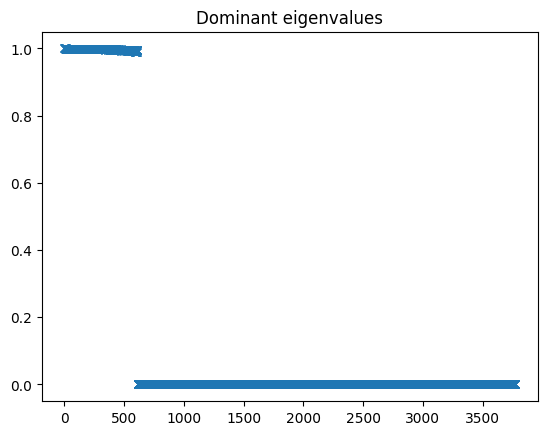

In [197]:
plt.plot(np.abs(edmd_adam.koopman_eigenvalues), 'x')
plt.title('Dominant eigenvalues');

In [198]:
edmd_adam.koopman_modes.shape

(3774, 3774)

In [199]:
sum(np.abs(edmd_adam.koopman_eigenvalues) > 0.9)

613

In [200]:
np.max(np.abs(edmd_adam.koopman_eigenvalues))

1.000050838046147

In [201]:
np.abs(edmd_adam_amp)

array([[1.07422549e+04],
       [1.12197470e+04],
       [4.44270243e+00],
       ...,
       [1.08359442e-02],
       [1.08359442e-02],
       [6.15831106e-04]])

In [206]:
edmd_adam_amp[np.abs(edmd_adam_amp) > 100]

array([ 10742.25489672-6.37097909e-09j, -11219.74698713+6.20627876e-09j,
        -5710.33765882-5.30263833e-10j,   1498.36280622-3.24064618e+03j,
         1498.36280622+3.24064618e+03j,   -250.13931514-7.67654028e+02j,
         -250.13931514+7.67654028e+02j,    265.77718642-1.16553763e+02j,
          265.77718642+1.16553763e+02j,   -178.66706333-2.67103559e+02j,
         -178.66706333+2.67103559e+02j,    143.31272712-1.22085690e+02j,
          143.31272712+1.22085690e+02j,   -367.22029163-2.48437015e+02j,
         -367.22029163+2.48437015e+02j,    823.08892196-1.86716420e-10j])

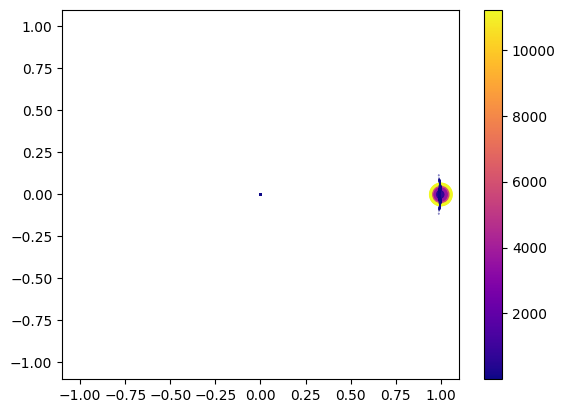

In [210]:
import matplotlib.pyplot as plt

ev = np.array(edmd_adam.koopman_eigenvalues.array)
fig,ax = plt.subplots()
plt.xlim((-1.1,1.1))
plt.ylim((-1.1,1.1))

amp_sub  = edmd_adam_amp[np.abs(edmd_adam_amp) > 1]

s = np.abs(edmd_adam_amp) * 1000/np.sum(np.abs(edmd_adam_amp))
p = ax.scatter(ev.real, ev.imag, s = s, c = np.abs(edmd_adam_amp), cmap="plasma")
fig.colorbar(p)

In [211]:
# predict a 1000 time steps more than the train dataset time steps
time_values_all = np.arange(0, w_tsc.shape[0] + 4000)
time_values_train = np.arange(0, w_tsc.shape[0])
time_values_test = np.arange(w_tsc.shape[0], w_tsc.shape[0] + 4000)
time_values_all.shape, time_values_train.shape, time_values_test.shape

((22000,), (18000,), (4000,))

In [212]:
edmd_adam_values = edmd_adam.predict(w_tsc.initial_states(), time_values=time_values_all)

len_koopman_matrix = len(edmd_adam.named_steps["dmd"].eigenvectors_right_)
print(f"shape of Koopman matrix: {len_koopman_matrix} x {len_koopman_matrix}")
#edmd_rbf.transform(tsc_data)

shape of Koopman matrix: 3774 x 3774


In [213]:
edmd_adam_values.shape

(22000, 3774)

In [214]:
edmd_adam_values

feature         0           1           2           3           4     \
ID time                                                                
0  0      229.595081  506.556409  640.774026   74.194680  344.828341   
   1      229.105178  506.044140  640.257843   73.823940  344.318677   
   2      228.610291  505.530408  639.740471   73.451770  343.806271   
   3      228.110583  505.011644  639.218023   73.078031  343.288539   
   4      227.605691  504.487245  638.689814   72.702335  342.765012   
...              ...         ...         ...         ...         ...   
   21995  327.977862   56.845533   16.713810  604.653845  172.824112   
   21996  328.013366   56.856727   16.720038  604.697343  172.847076   
   21997  328.048882   56.867925   16.726272  604.740848  172.870048   
   21998  328.084410   56.879129   16.732512  604.784359  172.893027   
   21999  328.119951   56.890337   16.738756  604.827877  172.916012   

feature         5           6           7           8           9     ...  \
ID time                                                               ...   
0  0      418.241924  136.481552   25.767577  558.058285  708.842700  ...   
   1      417.746278  136.035386   25.525216  557.551189  708.324332  ...   
   2      417.246244  135.585473   25.285473  557.041008  707.802960  ...   
   3      416.740519  135.131879   25.046529  556.525315  707.276575  ...   
   4      416.228560  134.674220   24.808080  556.003501  706.744487  ...   
...              ...         ...         ...         ...         ...  ...   
   21995  103.367037  486.697732  713.589459   37.379734    9.121325  ...   
   21996  103.382853  486.739546  713.633022   37.389061    9.125652  ...   
   21997  103.398675  486.781372  713.676592   37.398393    9.129987  ...   
   21998  103.414503  486.823208  713.720169   37.407730    9.134329  ...   
   21999  103.430336  486.865056  713.763752   37.417071    9.138677  ...   

feature       3764      3765      3766      3767      3768      3769  \
ID time                                                                
0  0     -0.276224  0.375153 -0.370109 -0.279772 -0.147659  0.173530   
   1     -0.278255  0.373145 -0.371401 -0.277635 -0.151258  0.171774   
   2     -0.277750  0.372345 -0.370643 -0.277030 -0.151023  0.171444   
   3     -0.277261  0.371572 -0.369901 -0.276377 -0.150787  0.171142   
   4     -0.276793  0.370823 -0.369175 -0.275680 -0.150550  0.170869   
...            ...       ...       ...       ...       ...       ...   
   21995  0.226803  1.044179 -0.754051 -0.477950 -0.301312  1.525277   
   21996  0.226875  1.044205 -0.754070 -0.477958 -0.301349  1.525310   
   21997  0.226947  1.044231 -0.754089 -0.477966 -0.301386  1.525342   
   21998  0.227020  1.044257 -0.754108 -0.477973 -0.301422  1.525375   
   21999  0.227092  1.044283 -0.754127 -0.477981 -0.301459  1.525407   

feature       3770      3771      3772      3773  
ID time                                           
0  0      0.356168  0.024629 -0.051362  0.303889  
   1      0.354295  0.027368 -0.049638  0.302635  
   2      0.353833  0.027237 -0.049532  0.302084  
   3      0.353309  0.027133 -0.049425  0.301485  
   4      0.352726  0.027061 -0.049318  0.300840  
...            ...       ...       ...       ...  
   21995  0.527268 -0.192012 -1.774937  0.722146  
   21996  0.527293 -0.192041 -1.774961  0.722137  
   21997  0.527318 -0.192070 -1.774986  0.722128  
   21998  0.527344 -0.192099 -1.775011  0.722118  
   21999  0.527369 -0.192128 -1.775037  0.722109  

[22000 rows x 3774 columns]

In [215]:
edmd_adam_values[1001]

feature       1001
ID time           
0  0     -0.010576
   1     -0.011345
   2     -0.011020
   3     -0.010671
   4     -0.010298
...            ...
   21995  0.362268
   21996  0.362291
   21997  0.362313
   21998  0.362335
   21999  0.362356

[22000 rows x 1 columns]

In [216]:
edmd_adam_values

feature         0           1           2           3           4     \
ID time                                                                
0  0      229.595081  506.556409  640.774026   74.194680  344.828341   
   1      229.105178  506.044140  640.257843   73.823940  344.318677   
   2      228.610291  505.530408  639.740471   73.451770  343.806271   
   3      228.110583  505.011644  639.218023   73.078031  343.288539   
   4      227.605691  504.487245  638.689814   72.702335  342.765012   
...              ...         ...         ...         ...         ...   
   21995  327.977862   56.845533   16.713810  604.653845  172.824112   
   21996  328.013366   56.856727   16.720038  604.697343  172.847076   
   21997  328.048882   56.867925   16.726272  604.740848  172.870048   
   21998  328.084410   56.879129   16.732512  604.784359  172.893027   
   21999  328.119951   56.890337   16.738756  604.827877  172.916012   

feature         5           6           7           8           9     ...  \
ID time                                                               ...   
0  0      418.241924  136.481552   25.767577  558.058285  708.842700  ...   
   1      417.746278  136.035386   25.525216  557.551189  708.324332  ...   
   2      417.246244  135.585473   25.285473  557.041008  707.802960  ...   
   3      416.740519  135.131879   25.046529  556.525315  707.276575  ...   
   4      416.228560  134.674220   24.808080  556.003501  706.744487  ...   
...              ...         ...         ...         ...         ...  ...   
   21995  103.367037  486.697732  713.589459   37.379734    9.121325  ...   
   21996  103.382853  486.739546  713.633022   37.389061    9.125652  ...   
   21997  103.398675  486.781372  713.676592   37.398393    9.129987  ...   
   21998  103.414503  486.823208  713.720169   37.407730    9.134329  ...   
   21999  103.430336  486.865056  713.763752   37.417071    9.138677  ...   

feature       3764      3765      3766      3767      3768      3769  \
ID time                                                                
0  0     -0.276224  0.375153 -0.370109 -0.279772 -0.147659  0.173530   
   1     -0.278255  0.373145 -0.371401 -0.277635 -0.151258  0.171774   
   2     -0.277750  0.372345 -0.370643 -0.277030 -0.151023  0.171444   
   3     -0.277261  0.371572 -0.369901 -0.276377 -0.150787  0.171142   
   4     -0.276793  0.370823 -0.369175 -0.275680 -0.150550  0.170869   
...            ...       ...       ...       ...       ...       ...   
   21995  0.226803  1.044179 -0.754051 -0.477950 -0.301312  1.525277   
   21996  0.226875  1.044205 -0.754070 -0.477958 -0.301349  1.525310   
   21997  0.226947  1.044231 -0.754089 -0.477966 -0.301386  1.525342   
   21998  0.227020  1.044257 -0.754108 -0.477973 -0.301422  1.525375   
   21999  0.227092  1.044283 -0.754127 -0.477981 -0.301459  1.525407   

feature       3770      3771      3772      3773  
ID time                                           
0  0      0.356168  0.024629 -0.051362  0.303889  
   1      0.354295  0.027368 -0.049638  0.302635  
   2      0.353833  0.027237 -0.049532  0.302084  
   3      0.353309  0.027133 -0.049425  0.301485  
   4      0.352726  0.027061 -0.049318  0.300840  
...            ...       ...       ...       ...  
   21995  0.527268 -0.192012 -1.774937  0.722146  
   21996  0.527293 -0.192041 -1.774961  0.722137  
   21997  0.527318 -0.192070 -1.774986  0.722128  
   21998  0.527344 -0.192099 -1.775011  0.722118  
   21999  0.527369 -0.192128 -1.775037  0.722109  

[22000 rows x 3774 columns]

In [217]:
edmd_adam_values.to_pickle("edmd_adam_predict_600.pkl")

In [218]:
edmd_adam.koopman_eigenvalues.shape

(3774,)

In [219]:
edmd_adam.koopman_eigenfunction

<bound method EDMD.koopman_eigenfunction of EDMD(dict_steps=[('identity', TSCIdentity())], dmd_model=DMDFull(),
     include_id_state=False)>

In [220]:
import matplotlib.pyplot as plt

In [221]:
edmd_adam_values[1001].iloc[time_values_train]

feature       1001
ID time           
0  0     -0.010576
   1     -0.011345
   2     -0.011020
   3     -0.010671
   4     -0.010298
...            ...
   17995  0.258588
   17996  0.258635
   17997  0.258682
   17998  0.258728
   17999  0.258775

[18000 rows x 1 columns]

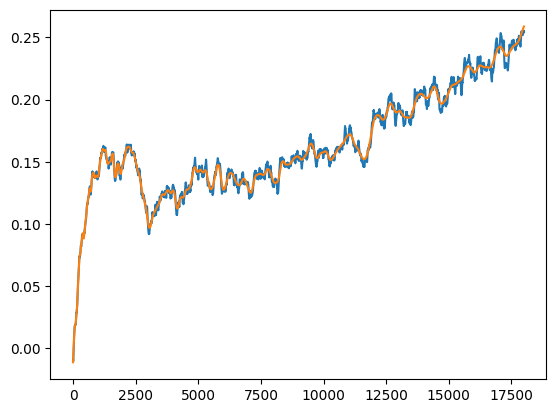

In [222]:
plt.plot(time_values_train, w_t_combined[:,1001])
plt.plot(time_values_train, edmd_adam_values[1001].iloc[time_values_train])

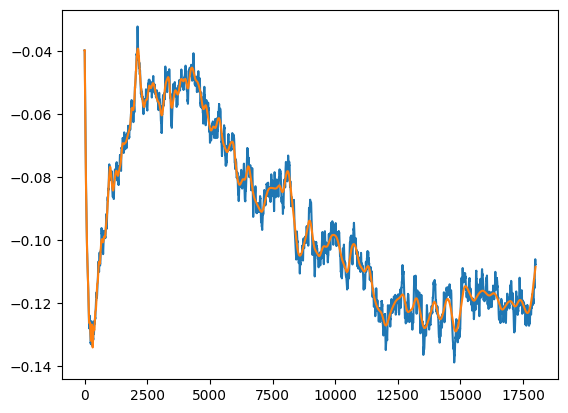

In [223]:
plt.plot(time_values_train, w_t_combined[:,3000])
plt.plot(time_values_train, edmd_adam_values[3000].iloc[time_values_train])

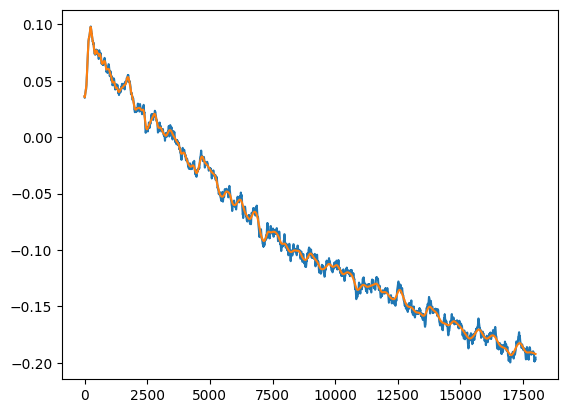

In [224]:
plt.plot(time_values_train, w_t_combined[:,2500])
plt.plot(time_values_train, edmd_adam_values[2500].iloc[time_values_train])

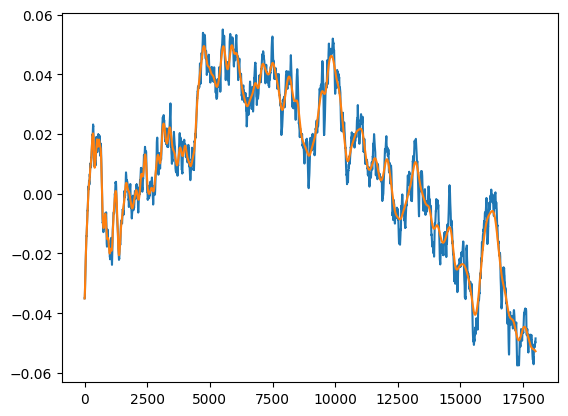

In [225]:
plt.plot(time_values_train, w_t_combined[:,3200])
plt.plot(time_values_train, edmd_adam_values[3200].iloc[time_values_train])

In [226]:
edmd_adam.koopman_modes

,evec0,evec1,evec2,evec3,evec4,evec5,evec6,evec7,evec8,evec9,...,evec3764,evec3765,evec3766,evec3767,evec3768,evec3769,evec3770,evec3771,evec3772,evec3773
feature,,,,,,,,,,,,,,,,,,,,,
0,0.064746+0.000000j,0.063158+0.000000j,0.033221+0.058882j,0.033221-0.058882j,0.054132+0.027367j,0.054132-0.027367j,0.022665+0.040500j,0.022665-0.040500j,-0.019028+0.037988j,-0.019028-0.037988j,...,-0.001812-0.010249j,-0.001812+0.010249j,-0.019316-0.029862j,-0.019316+0.029862j,0.018039+0.000000j,0.016232+0.010958j,0.016232-0.010958j,-0.005990+0.011790j,-0.005990-0.011790j,-0.009564+0.000000j
1,0.030061+0.000000j,0.032777+0.000000j,0.014260+0.012472j,0.014260-0.012472j,0.010229-0.009245j,0.010229+0.009245j,0.005922+0.029338j,0.005922-0.029338j,-0.006910+0.001042j,-0.006910-0.001042j,...,-0.010099-0.009389j,-0.010099+0.009389j,-0.034381-0.023445j,-0.034381+0.023445j,0.003914+0.000000j,-0.003229+0.019024j,-0.003229-0.019024j,0.009453+0.012035j,0.009453-0.012035j,-0.001271+0.000000j
2,0.018486+0.000000j,0.020809+0.000000j,0.010584+0.006920j,0.010584-0.006920j,0.008095-0.009520j,0.008095+0.009520j,-0.005334+0.038238j,-0.005334-0.038238j,-0.001183-0.019481j,-0.001183+0.019481j,...,0.000540-0.001187j,0.000540+0.001187j,-0.003603-0.038226j,-0.003603+0.038226j,0.000166+0.000000j,-0.012092-0.002685j,-0.012092+0.002685j,0.032154-0.013476j,0.032154+0.013476j,0.062632+0.000000j
3,0.043119+0.000000j,0.028414+0.000000j,0.046741+0.061904j,0.046741-0.061904j,0.105664+0.053608j,0.105664-0.053608j,0.076680+0.019929j,0.076680-0.019929j,0.051981+0.021937j,0.051981-0.021937j,...,0.012779-0.011133j,0.012779+0.011133j,0.001515-0.001373j,0.001515+0.001373j,0.019324+0.000000j,-0.003950+0.000142j,-0.003950-0.000142j,0.025032+0.001726j,0.025032-0.001726j,0.023712+0.000000j
4,0.051790+0.000000j,0.053696+0.000000j,0.010648+0.031454j,0.010648-0.031454j,0.024637+0.005083j,0.024637-0.005083j,0.016198+0.020381j,0.016198-0.020381j,-0.007385+0.032462j,-0.007385-0.032462j,...,0.049621+0.020293j,0.049621-0.020293j,-0.003612+0.012538j,-0.003612-0.012538j,0.015476+0.000000j,-0.015525+0.007877j,-0.015525-0.007877j,-0.000857+0.003827j,-0.000857-0.003827j,0.048950+0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,-0.000149+0.000000j,-0.000226+0.000000j,0.000051-0.000000j,0.000051+0.000000j,0.000194+0.000019j,0.000194-0.000019j,0.000003-0.000849j,0.000003+0.000849j,-0.000101+0.000106j,-0.000101-0.000106j,...,-0.007973+0.006181j,-0.007973-0.006181j,0.005836+0.008450j,0.005836-0.008450j,-0.016149+0.000000j,-0.007652-0.000769j,-0.007652+0.000769j,0.000591-0.005778j,0.000591+0.005778j,0.000173+0.000000j
3770,-0.000015+0.000000j,-0.000036+0.000000j,0.000036-0.000029j,0.000036+0.000029j,0.000357-0.000039j,0.000357+0.000039j,-0.000309+0.000342j,-0.000309-0.000342j,-0.000424+0.000215j,-0.000424-0.000215j,...,-0.012569-0.005652j,-0.012569+0.005652j,-0.002534-0.005704j,-0.002534+0.005704j,0.010346+0.000000j,0.005945+0.002253j,0.005945-0.002253j,0.012401+0.001422j,0.012401-0.001422j,0.010776+0.000000j
3771,-0.000082+0.000000j,-0.000088+0.000000j,-0.000148+0.000170j,-0.000148-0.000170j,0.000150+0.000770j,0.000150-0.000770j,0.000104-0.000054j,0.000104+0.000054j,0.000279-0.000086j,0.000279+0.000086j,...,-0.004597-0.005498j,-0.004597+0.005498j,-0.007867-0.001193j,-0.007867+0.001193j,-0.010293+0.000000j,-0.008633+0.004146j,-0.008633-0.004146j,-0.008161+0.001207j,-0.008161-0.001207j,-0.013728+0.000000j


In [227]:
edmd_adam.koopman_modes.describe()

,evec0,evec1,evec2,evec3,evec4,evec5,evec6,evec7,evec8,evec9,...,evec3764,evec3765,evec3766,evec3767,evec3768,evec3769,evec3770,evec3771,evec3772,evec3773
count,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,...,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j
mean,0.005893+0.000000j,0.005885+0.000000j,0.003205+0.004100j,0.003205-0.004100j,0.003628+0.000848j,0.003628-0.000848j,0.001540+0.005232j,0.001540-0.005232j,0.000616+0.001228j,0.000616-0.001228j,...,-0.000009+0.000007j,-0.000009-0.000007j,-0.000113-0.000045j,-0.000113+0.000045j,0.000262+0.000000j,0.000006-0.000012j,0.000006+0.000012j,0.000136+0.000029j,0.000136-0.000029j,0.000240+0.000000j
std,0.015176+0.000000j,0.015179+0.000000j,0.015426+0.000000j,0.015426+0.000000j,0.015848+0.000000j,0.015848+0.000000j,0.015339+0.000000j,0.015339+0.000000j,0.016222+0.000000j,0.016222+0.000000j,...,0.016280+0.000000j,0.016280+0.000000j,0.016280+0.000000j,0.016280+0.000000j,0.016278+0.000000j,0.016280+0.000000j,0.016280+0.000000j,0.016279+0.000000j,0.016279+0.000000j,0.016278+0.000000j
min,-0.000721+0.000000j,-0.031489+0.000000j,-0.001003-0.000243j,-0.001003+0.000243j,-0.119083-0.000000j,-0.119083+0.000000j,-0.017012+0.047843j,-0.017012-0.047843j,-0.023951+0.026937j,-0.023951-0.026937j,...,-0.082047-0.022599j,-0.082047+0.022599j,-0.077510+0.000487j,-0.077510-0.000487j,-0.155334+0.000000j,-0.082382+0.000000j,-0.082382-0.000000j,-0.100003+0.000000j,-0.100003-0.000000j,-0.123787+0.000000j
25%,-0.000033+0.000000j,-0.000042+0.000000j,-0.000118+0.000102j,-0.000118-0.000102j,-0.000511+0.000093j,-0.000511-0.000093j,-0.000759-0.000596j,-0.000759+0.000596j,-0.000596-0.001263j,-0.000596+0.001263j,...,-0.006945+0.000525j,-0.006945-0.000525j,-0.005802+0.006498j,-0.005802-0.006498j,-0.009805+0.000000j,-0.007570+0.003764j,-0.007570-0.003764j,-0.006896+0.002525j,-0.006896-0.002525j,-0.008682+0.000000j
50%,0.000006+0.000000j,0.000006+0.000000j,0.000045+0.000014j,0.000045-0.000014j,0.000184-0.001075j,0.000184+0.001075j,-0.000042-0.001024j,-0.000042+0.001024j,0.000021-0.000158j,0.000021+0.000158j,...,-0.000196+0.002610j,-0.000196-0.002610j,-0.000057+0.000473j,-0.000057-0.000473j,-0.000054+0.000000j,-0.000212+0.006160j,-0.000212-0.006160j,0.000598-0.012968j,0.000598+0.012968j,0.000544+0.000000j
75%,0.000060+0.000000j,0.000073+0.000000j,0.000279-0.000091j,0.000279+0.000091j,0.001079-0.000697j,0.001079+0.000697j,0.000773+0.000716j,0.000773-0.000716j,0.000623-0.000410j,0.000623+0.000410j,...,0.006691-0.006222j,0.006691+0.006222j,0.005677-0.000617j,0.005677+0.000617j,0.010573+0.000000j,0.007371-0.003688j,0.007371+0.003688j,0.007143-0.003007j,0.007143+0.003007j,0.009371+0.000000j
max,0.064746+0.000000j,0.063596+0.000000j,0.089329+0.000000j,0.089329-0.000000j,0.105880+0.050388j,0.105880-0.050388j,0.083609-0.000000j,0.083609+0.000000j,0.276257-0.000000j,0.276257+0.000000j,...,0.105370-0.000000j,0.105370+0.000000j,0.108164+0.000000j,0.108164-0.000000j,0.090936+0.000000j,0.077447+0.013209j,0.077447-0.013209j,0.074480+0.005827j,0.074480-0.005827j,0.097561+0.000000j


### predict beyond time values in fit dataset

In [228]:
time_values_test = np.arange(w_tsc.shape[0], w_tsc.shape[0] + 2000)


In [124]:
time_values_test.shape

(2000,)

In [125]:
test_w_adam = np.load("test_w_adam_nn.pkl.npy")
test_w_adam.shape

(12017, 3174)

In [126]:
edmd_adam_values.shape

(22000, 3774)

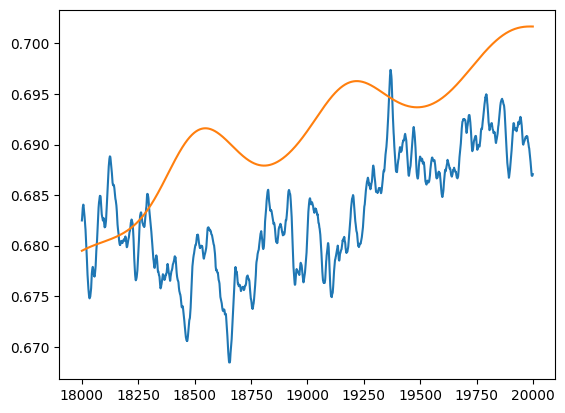

In [127]:
plt.plot(time_values_test, test_w_adam[0:2000, 3173])
plt.plot(time_values_test, edmd_adam_values[3173 + 600].iloc[time_values_test])

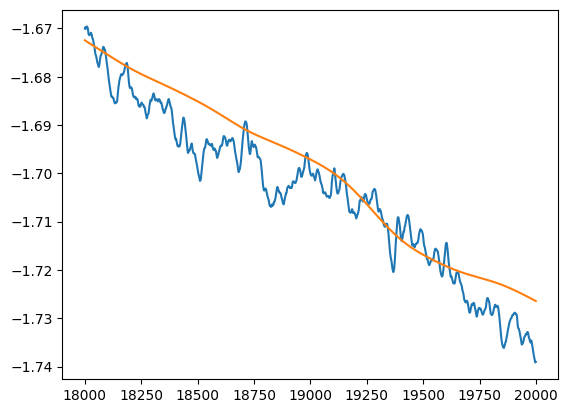

In [128]:
plt.plot(time_values_test, test_w_adam[0:2000, 3172])
plt.plot(time_values_test, edmd_adam_values[3172 + 600].iloc[time_values_test])

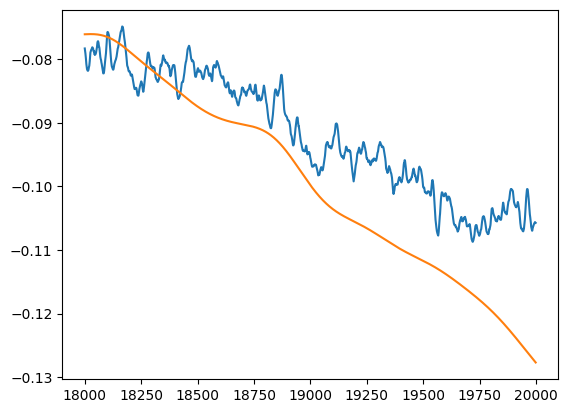

In [129]:
plt.plot(time_values_test, test_w_adam[0:2000, 3171])
plt.plot(time_values_test, edmd_adam_values[3171 + 600].iloc[time_values_test])

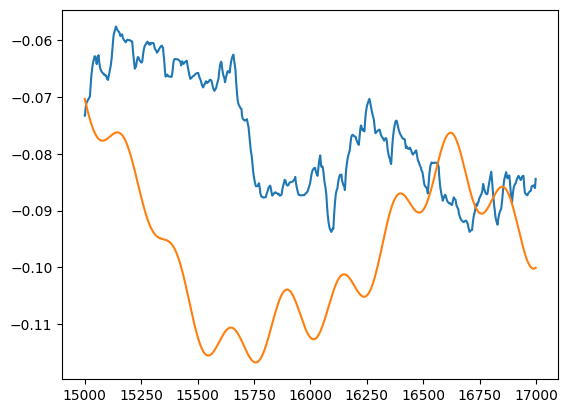

In [105]:
plt.plot(time_values_test, test_w_adam[0:2000, 2100])
plt.plot(time_values_test, edmd_adam_values[2100 + 600].iloc[time_values_test])

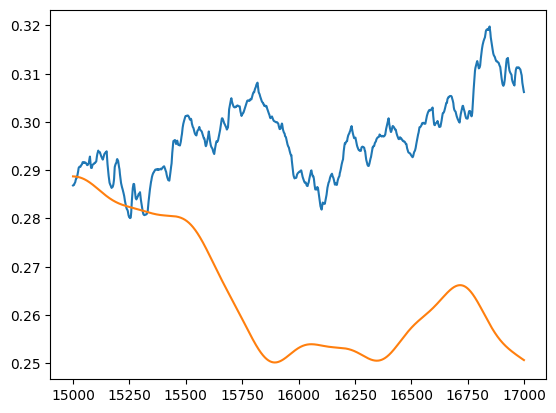

In [106]:
plt.plot(time_values_test, test_w_adam[0:2000, 3000])
plt.plot(time_values_test, edmd_adam_values[3000 + 600].iloc[time_values_test])

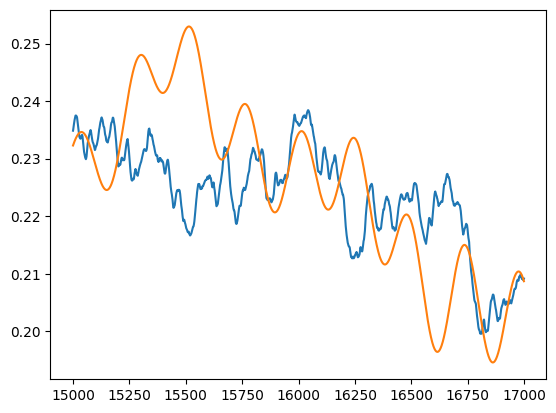

In [107]:
plt.plot(time_values_test, test_w_adam[0:2000, 50])
plt.plot(time_values_test, edmd_adam_values[50 + 600].iloc[time_values_test])

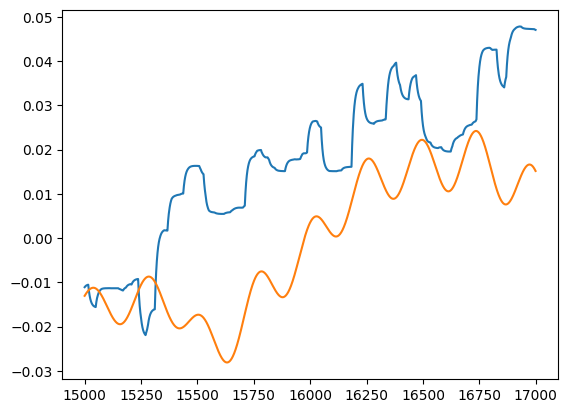

In [108]:
plt.plot(time_values_test, test_w_adam[0:2000, 1])
plt.plot(time_values_test, edmd_adam_values[1 + 600].iloc[time_values_test])

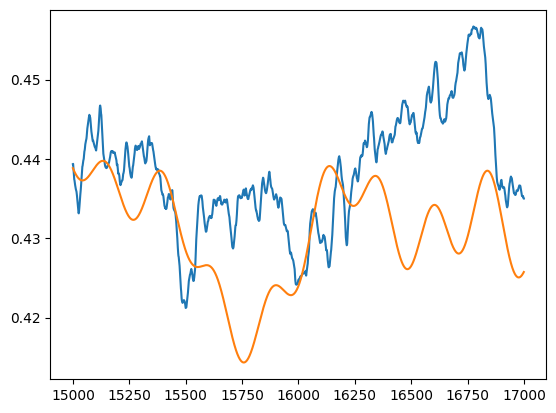

In [109]:
plt.plot(time_values_test, test_w_adam[0:2000, 100])
plt.plot(time_values_test, edmd_adam_values[100 + 600].iloc[time_values_test])

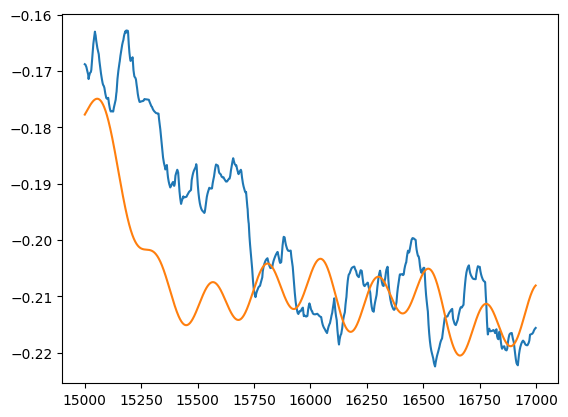

In [110]:
plt.plot(time_values_test, test_w_adam[0:2000, 1050])
plt.plot(time_values_test, edmd_adam_values[1050 + 600].iloc[time_values_test])

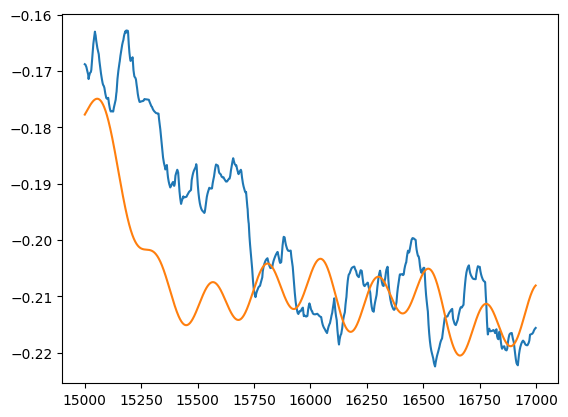

In [111]:
plt.plot(time_values_test, test_w_adam[0:2000, 1050])
plt.plot(time_values_test, edmd_adam_values[1050 + 600].iloc[time_values_test])

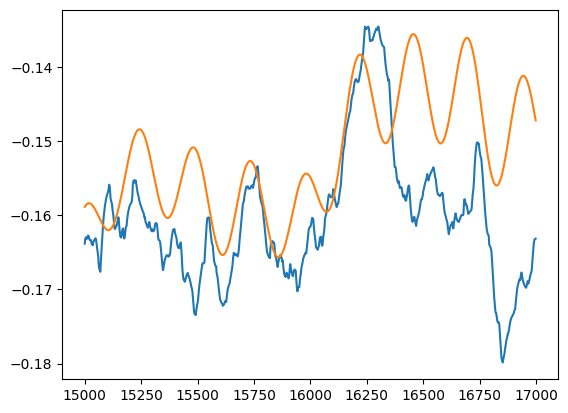

In [114]:
plt.plot(time_values_test, test_w_adam[0:2000, 1048])
plt.plot(time_values_test, edmd_adam_values[1048 + 600].iloc[time_values_test])

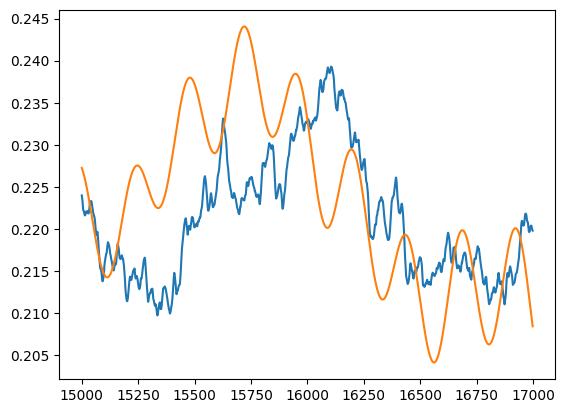

In [115]:
plt.plot(time_values_test, test_w_adam[0:2000, 2048])
plt.plot(time_values_test, edmd_adam_values[2048 + 600].iloc[time_values_test])

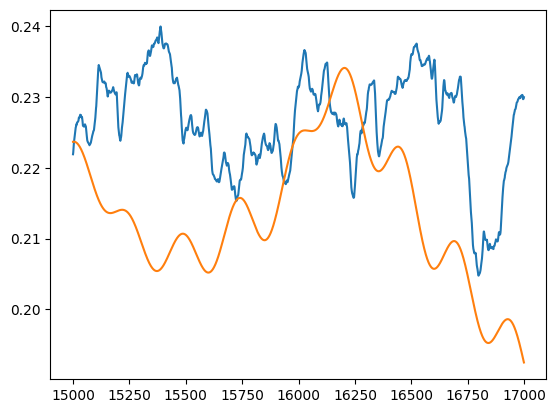

In [117]:
plt.plot(time_values_test, test_w_adam[0:2000, 10])
plt.plot(time_values_test, edmd_adam_values[10 + 600].iloc[time_values_test])

## Apply edmd to sgd trainied NN

In [229]:
w = np.load("w_sgd_nn.pkl.npy")

In [230]:
w

array([[-0.00326786, -0.02545078, -0.00450276, ...,  0.02462918,
        -0.05136228,  0.30388865],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.0246772 ,
        -0.05131335,  0.30387801],
       [-0.00326786, -0.02545078, -0.00450276, ...,  0.0246474 ,
        -0.05124811,  0.30380434],
       ...,
       [-0.00315591, -0.02436608, -0.00164602, ...,  0.26548493,
        -0.20785919,  0.27432153],
       [-0.00315591, -0.02436608, -0.00164602, ...,  0.2654852 ,
        -0.20784703,  0.27433386],
       [-0.00315591, -0.02436608, -0.00164599, ...,  0.26545691,
        -0.2078331 ,  0.27437395]])

In [231]:
w.shape

(18000, 3174)

In [232]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = KMeans(600, verbose=1, init='k-means++', n_init=1, random_state=11)
kmeans.fit(w)
#def get_centers_knn():

identified_clusters = kmeans.fit_predict(w)
identified_clusters
unique, counts = np.unique(identified_clusters, return_counts=True)

centers = kmeans.cluster_centers_
centers

Initialization complete
Iteration 0, inertia 0.22489504126828672.
Iteration 1, inertia 0.17630318777449364.
Iteration 2, inertia 0.1735731484255174.
Iteration 3, inertia 0.1722988631548283.
Iteration 4, inertia 0.17157958030229994.
Iteration 5, inertia 0.17109515614395998.
Iteration 6, inertia 0.1707705629070188.
Iteration 7, inertia 0.17054473725807365.
Iteration 8, inertia 0.17039499697258187.
Iteration 9, inertia 0.1702948667840853.
Iteration 10, inertia 0.1702394585574827.
Iteration 11, inertia 0.17018474608421374.
Iteration 12, inertia 0.1701411743231331.
Iteration 13, inertia 0.17009942566569888.
Iteration 14, inertia 0.17007498476671262.
Iteration 15, inertia 0.17004921927235292.
Iteration 16, inertia 0.170023597885025.
Iteration 17, inertia 0.16999858735756837.
Iteration 18, inertia 0.1699784380304393.
Iteration 19, inertia 0.1699507878491275.
Iteration 20, inertia 0.16991594887529937.
Iteration 21, inertia 0.1698849158122387.
Iteration 22, inertia 0.1698687350522905.
Iteration

array([[-0.00316503, -0.02489205, -0.00316294, ...,  0.23893519,
        -0.1405173 ,  0.26785212],
       [-0.00324514, -0.02541501, -0.0044862 , ...,  0.11689107,
        -0.04039338,  0.19959347],
       [-0.0031513 , -0.02450008, -0.00205069, ...,  0.26058381,
        -0.18881885,  0.27410803],
       ...,
       [-0.00324973, -0.02542621, -0.00450176, ...,  0.08438796,
        -0.03603401,  0.2027604 ],
       [-0.00326697, -0.02545159, -0.00449854, ...,  0.02953937,
        -0.04943587,  0.2908496 ],
       [-0.00325167, -0.02543114, -0.00450849, ...,  0.07128683,
        -0.03900858,  0.2163843 ]])

In [233]:
w_t_transformed = np.apply_along_axis(lambda x: rbf_thin_plate(centers,x), 1, w)
w_t_transformed.shape

(18000, 600)

In [234]:
w_t_transformed.shape

(18000, 600)

In [235]:
w_t_combined = np.hstack((w_t_transformed, w))
w_t_combined.shape

(18000, 3774)

In [236]:
np.save("w_t_combined_sgd.pkl", w_t_combined)

In [237]:
w_t_combined = np.load("w_t_combined_sgd.pkl.npy")
w_t_combined.shape

(18000, 3774)

In [238]:
from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis, TSCIdentity, TSCApplyLambdas, TSCFeaturePreprocess
from datafold.pcfold import GaussianKernel, TSCDataFrame

In [239]:
w_tsc = TSCDataFrame.from_single_timeseries(pd.DataFrame(w_t_combined))
w_tsc.shape

(18000, 3774)

In [240]:
print(f"time delta: {w_tsc.delta_time}")
print(f"#time series: {w_tsc.n_timeseries}")
print(f"#time steps per time series: {w_tsc.n_timesteps}")
print(f"(n_samples, n_features): {w_tsc.shape}")
print(f"time interval {w_tsc.time_interval()}")
print(f"Same time values: {w_tsc.is_same_time_values()}")

time delta: 1
#time series: 1
#time steps per time series: 18000
(n_samples, n_features): (18000, 3774)
time interval (0, 17999)
Same time values: True


In [241]:
dict_step = [
    (
        "identity",
        TSCIdentity()
    )
]

edmd_sgd = EDMD(dict_steps=dict_step, include_id_state=False).fit(
    X=w_tsc
)  # Note that the "extended" part is in the transformations


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(3774, 3774)) has not full rank (=167), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [242]:
edmd_sgd

EDMD(dict_steps=[('identity', TSCIdentity())], dmd_model=DMDFull(),
     include_id_state=False)

In [243]:
import pickle
with open('edmd_sgd.pkl', 'wb') as outp:
    pickle.dump(edmd_sgd, outp, pickle.HIGHEST_PROTOCOL)


In [38]:
with open('edmd_sgd.pkl', 'rb') as inp:
    edmd_adam = pickle.load(inp)

In [125]:
with open('edmd_sgd.pkl', 'rb') as inp:
    edmd_sgd = pickle.load(inp)

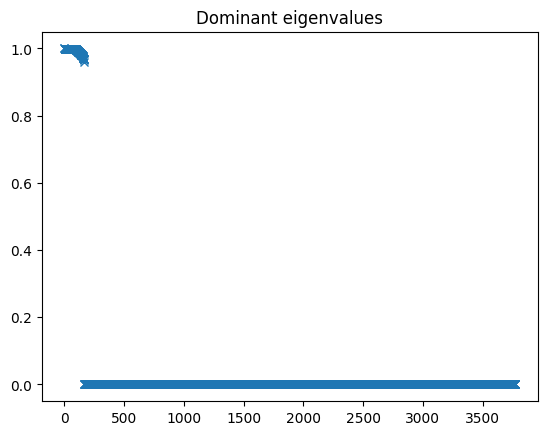

In [251]:
plt.plot(np.abs(edmd_sgd.koopman_eigenvalues), 'x')
plt.title('Dominant eigenvalues');

In [262]:
sum(np.abs(edmd_sgd.koopman_eigenvalues) > 0.9)

167

In [253]:
sum(np.abs(edmd_adam.koopman_eigenvalues) > 0.8)

613

In [254]:
sum(np.abs(edmd_adam.koopman_eigenvalues) > 0.9)

613

In [255]:
np.max(np.abs(edmd_adam.koopman_eigenvalues))

1.000050838046147

In [256]:
w_ic = w_tsc.initial_states().to_numpy().T
edmd_sgd_amp = edmd_sgd.dmd_model.compute_spectral_system_states(w_ic)
edmd_sgd_amp.shape

(3774, 1)

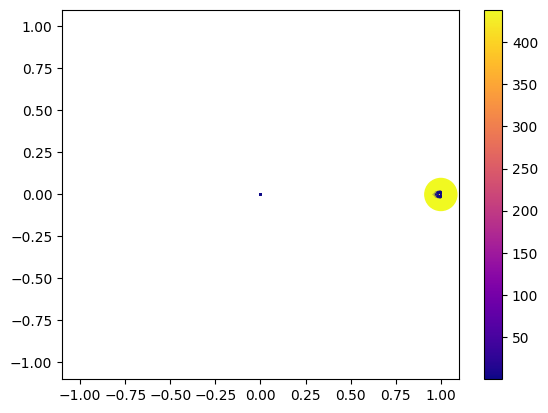

In [261]:
import matplotlib.pyplot as plt

ev = np.array(edmd_sgd.koopman_eigenvalues.array)
fig,ax = plt.subplots()
plt.xlim((-1.1,1.1))
plt.ylim((-1.1,1.1))

amp_sub  = edmd_sgd_amp[np.abs(edmd_sgd_amp) > 1]

s = np.abs(edmd_sgd_amp) * 1000/np.sum(np.abs(edmd_sgd_amp))
p = ax.scatter(ev.real, ev.imag, s = s, c = np.abs(edmd_sgd_amp), cmap="plasma")
fig.colorbar(p)

In [165]:
# predict a 1000 time steps more than the train dataset time steps
time_values_all = np.arange(0, w_tsc.shape[0] + 4000)
time_values_train = np.arange(0, w_tsc.shape[0])
time_values_test = np.arange(w_tsc.shape[0], w_tsc.shape[0] + 4000)
time_values_all.shape, time_values_train.shape, time_values_test.shape

((19000,), (15000,), (4000,))

In [166]:
edmd_sgd_values = edmd_sgd.predict(w_tsc.initial_states(), time_values=time_values_all)

len_koopman_matrix = len(edmd_sgd.named_steps["dmd"].eigenvectors_right_)
print(f"shape of Koopman matrix: {len_koopman_matrix} x {len_koopman_matrix}")
#edmd_rbf.transform(tsc_data)

shape of Koopman matrix: 3774 x 3774


In [37]:
edmd_sgd_values.shape

(19000, 3474)

In [167]:
edmd_sgd_values[1001]

feature       1001
ID time           
0  0     -0.010576
   1     -0.010567
   2     -0.010567
   3     -0.010566
   4     -0.010565
...            ...
   18995  0.029837
   18996  0.029838
   18997  0.029840
   18998  0.029841
   18999  0.029842

[19000 rows x 1 columns]

In [168]:
edmd_sgd_values

feature       0          1          2          3          4          5     \
ID time                                                                     
0  0      7.500016   0.253530  19.674684  -0.154644   2.627817  12.817789   
   1      7.498406   0.253147  19.672282  -0.154489   2.626829  12.815755   
   2      7.496801   0.252759  19.669878  -0.154355   2.625826  12.813733   
   3      7.495193   0.252369  19.667467  -0.154225   2.624821  12.811705   
   4      7.493583   0.251976  19.665048  -0.154097   2.623814  12.809673   
...            ...        ...        ...        ...        ...        ...   
   18995  4.243321  19.161937   0.553916  29.536990  10.426713   1.655655   
   18996  4.244189  19.163500   0.554539  29.539045  10.427849   1.656360   
   18997  4.245057  19.165064   0.555161  29.541099  10.428984   1.657065   
   18998  4.245926  19.166627   0.555784  29.543154  10.430120   1.657771   
   18999  4.246794  19.168190   0.556407  29.545208  10.431255   1.658476   

feature        6          7         8          9     ...      3764      3765  \
ID time                                              ...                       
0  0      21.941024  -0.136742  4.803709   0.990254  ... -0.276224  0.375153   
   1      21.938519  -0.136823  4.802404   0.989612  ... -0.276083  0.375203   
   2      21.936014  -0.136927  4.801089   0.988960  ... -0.276068  0.375172   
   3      21.933500  -0.137034  4.799771   0.988306  ... -0.276053  0.375141   
   4      21.930977  -0.137144  4.798451   0.987649  ... -0.276037  0.375110   
...             ...        ...       ...        ...  ...       ...       ...   
   18995   0.455041  24.438190  6.874650  15.114424  ... -0.359229  0.217307   
   18996   0.455648  24.440044  6.875645  15.115744  ... -0.359209  0.217308   
   18997   0.456256  24.441898  6.876640  15.117064  ... -0.359189  0.217309   
   18998   0.456864  24.443752  6.877635  15.118383  ... -0.359169  0.217310   
   18999   0.457472  24.445606  6.878631  15.119703  ... -0.359149  0.217311   

feature       3766      3767      3768      3769      3770      3771  \
ID time                                                                
0  0     -0.370109 -0.279772 -0.147659  0.173530  0.356168  0.024629   
   1     -0.370143 -0.279604 -0.147599  0.173318  0.356197  0.024702   
   2     -0.370113 -0.279570 -0.147580  0.173327  0.356152  0.024710   
   3     -0.370083 -0.279535 -0.147561  0.173334  0.356106  0.024718   
   4     -0.370053 -0.279500 -0.147543  0.173341  0.356060  0.024726   
...            ...       ...       ...       ...       ...       ...   
   18995 -0.377333 -0.072432 -0.079498  0.391310  0.053839  0.253883   
   18996 -0.377331 -0.072445 -0.079494  0.391299  0.053848  0.253874   
   18997 -0.377329 -0.072457 -0.079490  0.391288  0.053856  0.253865   
   18998 -0.377326 -0.072470 -0.079486  0.391278  0.053864  0.253856   
   18999 -0.377324 -0.072483 -0.079482  0.391267  0.053872  0.253846   

feature       3772      3773  
ID time                       
0  0     -0.051362  0.303889  
   1     -0.051549  0.303801  
   2     -0.051551  0.303765  
   3     -0.051552  0.303729  
   4     -0.051553  0.303693  
...            ...       ...  
   18995 -0.223614  0.291375  
   18996 -0.223622  0.291374  
   18997 -0.223629  0.291374  
   18998 -0.223636  0.291373  
   18999 -0.223643  0.291373  

[19000 rows x 3774 columns]

In [169]:
edmd_sgd_values.to_pickle("edmd_sgd_predict_600.pkl")

In [174]:
edmd_sgd.koopman_eigenvalues.shape

(3774,)

In [175]:
import matplotlib.pyplot as plt

In [176]:
edmd_sgd_values[1001].iloc[time_values_train]

feature       1001
ID time           
0  0     -0.010576
   1     -0.010567
   2     -0.010567
   3     -0.010566
   4     -0.010565
...            ...
   14995  0.023594
   14996  0.023596
   14997  0.023597
   14998  0.023599
   14999  0.023600

[15000 rows x 1 columns]

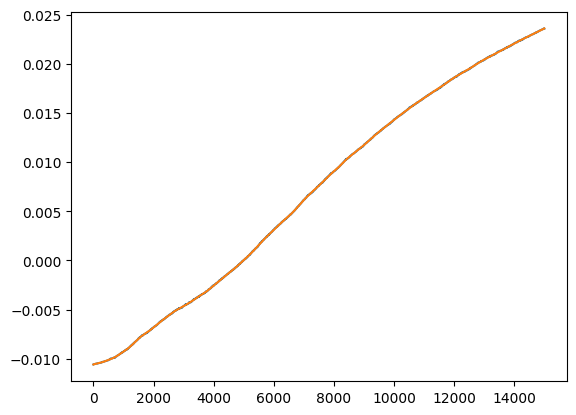

In [177]:
plt.plot(time_values_train, w_t_combined[:,1001])
plt.plot(time_values_train, edmd_sgd_values[1001].iloc[time_values_train])

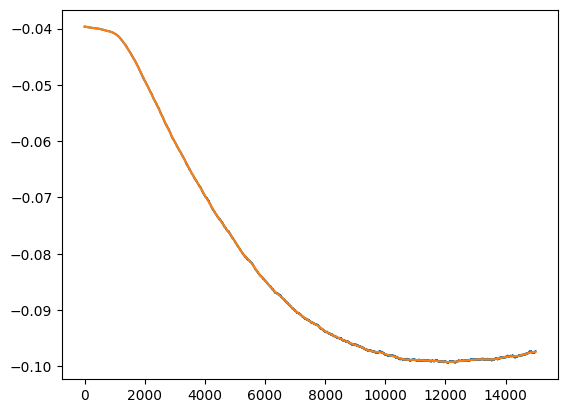

In [178]:
plt.plot(time_values_train, w_t_combined[:,3000])
plt.plot(time_values_train, edmd_sgd_values[3000].iloc[time_values_train])

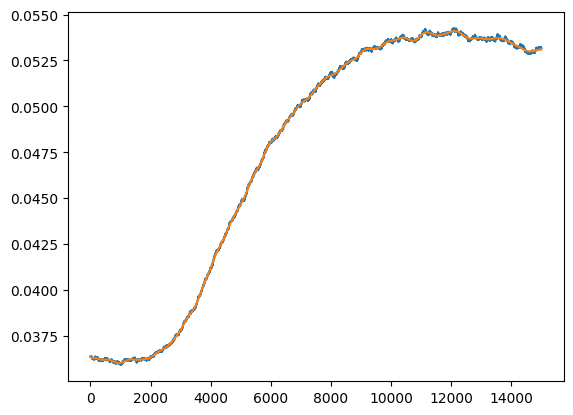

In [179]:
plt.plot(time_values_train, w_t_combined[:,2500])
plt.plot(time_values_train, edmd_sgd_values[2500].iloc[time_values_train])

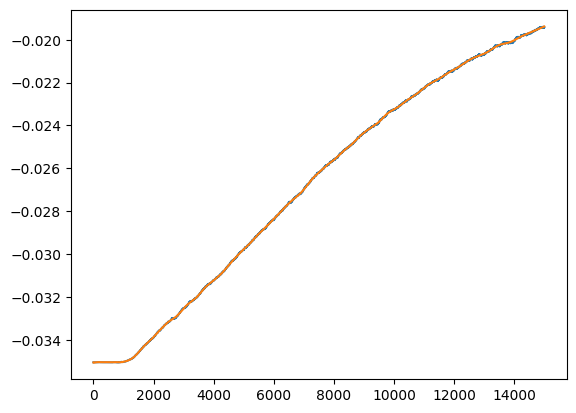

In [180]:
plt.plot(time_values_train, w_t_combined[:,3200])
plt.plot(time_values_train, edmd_sgd_values[3200].iloc[time_values_train])

In [181]:
edmd_sgd.koopman_modes

,evec0,evec1,evec2,evec3,evec4,evec5,evec6,evec7,evec8,evec9,...,evec3764,evec3765,evec3766,evec3767,evec3768,evec3769,evec3770,evec3771,evec3772,evec3773
feature,,,,,,,,,,,,,,,,,,,,,
0,0.015197-0.014466j,0.015197+0.014466j,0.001232-0.013896j,0.001232+0.013896j,0.054243+0.026638j,0.054243-0.026638j,0.028326-0.040208j,0.028326+0.040208j,0.000864+0.032827j,0.000864-0.032827j,...,-0.003278-0.007110j,-0.003278+0.007110j,-0.015341+0.000000j,-0.001605-0.001614j,-0.001605+0.001614j,-0.006003-0.003481j,-0.006003+0.003481j,-0.013209-0.002690j,-0.013209+0.002690j,-0.010993+0.000000j
1,0.049896-0.011707j,0.049896+0.011707j,-0.027440-0.002768j,-0.027440+0.002768j,-0.001607-0.022780j,-0.001607+0.022780j,-0.033115-0.016662j,-0.033115+0.016662j,-0.050169+0.008443j,-0.050169-0.008443j,...,-0.000314-0.003831j,-0.000314+0.003831j,0.002582+0.000000j,-0.045239+0.004148j,-0.045239-0.004148j,0.005323-0.016646j,0.005323+0.016646j,0.008880-0.003773j,0.008880+0.003773j,-0.008970+0.000000j
2,0.007108-0.016341j,0.007108+0.016341j,-0.062001-0.018105j,-0.062001+0.018105j,0.029793-0.002008j,0.029793+0.002008j,0.027549-0.019208j,0.027549+0.019208j,0.050519-0.005946j,0.050519+0.005946j,...,0.004399+0.024742j,0.004399-0.024742j,0.004456+0.000000j,-0.033481+0.003096j,-0.033481-0.003096j,-0.027092-0.024912j,-0.027092+0.024912j,-0.012271-0.004931j,-0.012271+0.004931j,-0.017576+0.000000j
3,0.071281-0.004479j,0.071281+0.004479j,-0.028475-0.032873j,-0.028475+0.032873j,0.016501+0.013011j,0.016501-0.013011j,0.001547+0.005616j,0.001547-0.005616j,-0.006457+0.001769j,-0.006457-0.001769j,...,0.014884+0.005495j,0.014884-0.005495j,0.043029+0.000000j,-0.007098-0.010361j,-0.007098+0.010361j,0.063873-0.004779j,0.063873+0.004779j,0.050269+0.013117j,0.050269-0.013117j,-0.001482+0.000000j
4,0.029961-0.014712j,0.029961+0.014712j,-0.005614+0.009256j,-0.005614-0.009256j,-0.021242+0.019897j,-0.021242-0.019897j,0.027354+0.048475j,0.027354-0.048475j,0.058000-0.008656j,0.058000+0.008656j,...,-0.002556+0.006296j,-0.002556-0.006296j,-0.004616+0.000000j,0.018807-0.028149j,0.018807+0.028149j,-0.015162-0.036143j,-0.015162+0.036143j,-0.010222-0.027597j,-0.010222+0.027597j,-0.030422+0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,0.000559+0.000783j,0.000559-0.000783j,0.000782+0.000181j,0.000782-0.000181j,-0.000602+0.000071j,-0.000602-0.000071j,-0.000297-0.000290j,-0.000297+0.000290j,-0.000511-0.000629j,-0.000511+0.000629j,...,0.012914-0.011451j,0.012914+0.011451j,-0.001955+0.000000j,-0.014311-0.036585j,-0.014311+0.036585j,-0.015223-0.017034j,-0.015223+0.017034j,-0.019708-0.004062j,-0.019708+0.004062j,-0.012923+0.000000j
3770,0.000167-0.000165j,0.000167+0.000165j,-0.000403-0.000332j,-0.000403+0.000332j,0.000420+0.000032j,0.000420-0.000032j,-0.000085-0.000306j,-0.000085+0.000306j,-0.000692-0.000172j,-0.000692+0.000172j,...,-0.035040-0.009387j,-0.035040+0.009387j,-0.042918+0.000000j,0.021978-0.017794j,0.021978+0.017794j,-0.007341-0.038079j,-0.007341+0.038079j,0.002827-0.029188j,0.002827+0.029188j,-0.021488+0.000000j
3771,0.000336+0.000587j,0.000336-0.000587j,0.000655+0.000018j,0.000655-0.000018j,-0.000543+0.000237j,-0.000543-0.000237j,0.000049+0.000102j,0.000049-0.000102j,0.000430-0.000258j,0.000430+0.000258j,...,-0.006990-0.016225j,-0.006990+0.016225j,-0.015758+0.000000j,0.002488+0.001846j,0.002488-0.001846j,0.016433-0.003542j,0.016433+0.003542j,0.006667+0.002773j,0.006667-0.002773j,-0.015318+0.000000j


In [182]:
edmd_sgd.koopman_modes.describe()

,evec0,evec1,evec2,evec3,evec4,evec5,evec6,evec7,evec8,evec9,...,evec3764,evec3765,evec3766,evec3767,evec3768,evec3769,evec3770,evec3771,evec3772,evec3773
count,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,...,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j
mean,0.004814-0.002015j,0.004814+0.002015j,-0.004285-0.002247j,-0.004285+0.002247j,0.003514+0.000154j,0.003514-0.000154j,0.002463+0.000289j,0.002463-0.000289j,0.001598+0.000117j,0.001598-0.000117j,...,-0.000050-0.000037j,-0.000050+0.000037j,-0.000158+0.000000j,-0.000107-0.000104j,-0.000107+0.000104j,-0.000129+0.000020j,-0.000129-0.000020j,-0.000145-0.000050j,-0.000145+0.000050j,-0.000102+0.000000j
std,0.015421+0.000000j,0.015421+0.000000j,0.015544+0.000000j,0.015544+0.000000j,0.015896+0.000000j,0.015896+0.000000j,0.016090+0.000000j,0.016090+0.000000j,0.016201+0.000000j,0.016201+0.000000j,...,0.016280+0.000000j,0.016280+0.000000j,0.016279+0.000000j,0.016279+0.000000j,0.016279+0.000000j,0.016280+0.000000j,0.016280+0.000000j,0.016279+0.000000j,0.016279+0.000000j,0.016280+0.000000j
min,-0.001674-0.000988j,-0.001674+0.000988j,-0.068399-0.000000j,-0.068399+0.000000j,-0.026848+0.001246j,-0.026848-0.001246j,-0.040360+0.004107j,-0.040360-0.004107j,-0.050653+0.002261j,-0.050653-0.002261j,...,-0.123196-0.000000j,-0.123196+0.000000j,-0.207021+0.000000j,-0.112156-0.068684j,-0.112156+0.068684j,-0.140283-0.000000j,-0.140283+0.000000j,-0.104079-0.021944j,-0.104079+0.021944j,-0.175909+0.000000j
25%,-0.000024+0.000143j,-0.000024-0.000143j,-0.000061+0.000009j,-0.000061-0.000009j,-0.000066+0.000118j,-0.000066-0.000118j,-0.000123-0.000049j,-0.000123+0.000049j,-0.000200-0.000218j,-0.000200+0.000218j,...,-0.005354+0.002879j,-0.005354-0.002879j,-0.006776+0.000000j,-0.005095-0.001165j,-0.005095+0.001165j,-0.005374+0.001267j,-0.005374-0.001267j,-0.005559-0.000676j,-0.005559+0.000676j,-0.006112+0.000000j
50%,0.000049+0.000022j,0.000049-0.000022j,0.000000+0.000051j,0.000000-0.000051j,0.000012+0.000017j,0.000012-0.000017j,0.000005+0.000029j,0.000005-0.000029j,0.000001-0.000031j,0.000001+0.000031j,...,-0.000137-0.002225j,-0.000137+0.002225j,-0.000075+0.000000j,-0.000045-0.000924j,-0.000045+0.000924j,-0.000022-0.000745j,-0.000022+0.000745j,-0.000126-0.001283j,-0.000126+0.001283j,-0.000136+0.000000j
75%,0.000193+0.000241j,0.000193-0.000241j,0.000054+0.000106j,0.000054-0.000106j,0.000109+0.000018j,0.000109-0.000018j,0.000142-0.000015j,0.000142+0.000015j,0.000184+0.000144j,0.000184-0.000144j,...,0.005339-0.006658j,0.005339+0.006658j,0.006666+0.000000j,0.004841-0.002877j,0.004841+0.002877j,0.005026+0.004500j,0.005026-0.004500j,0.005061-0.005026j,0.005061+0.005026j,0.005918+0.000000j
max,0.080594+0.000000j,0.080594-0.000000j,0.003357-0.004603j,0.003357+0.004603j,0.065579-0.000000j,0.065579+0.000000j,0.067390+0.000000j,0.067390-0.000000j,0.058984-0.000000j,0.058984+0.000000j,...,0.104994+0.019208j,0.104994-0.019208j,0.170120+0.000000j,0.141577+0.000000j,0.141577-0.000000j,0.118878+0.002383j,0.118878-0.002383j,0.191037+0.000000j,0.191037-0.000000j,0.255777+0.000000j


### predict beyond time values in fit dataset

In [183]:
time_values_test = np.arange(w_tsc.shape[0], w_tsc.shape[0] + 2000)


In [184]:
time_values_test.shape

(2000,)

In [185]:
test_w_sgd = np.load("test_w_sgd_nn.pkl.npy")
test_w_sgd.shape

(4551, 3174)

In [186]:
edmd_sgd_values.shape

(19000, 3774)

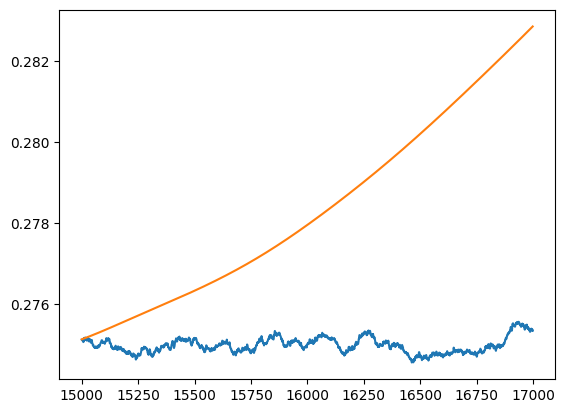

In [187]:
plt.plot(time_values_test, test_w_sgd[0:2000, 3173])
plt.plot(time_values_test, edmd_sgd_values[3173 + 600].iloc[time_values_test])

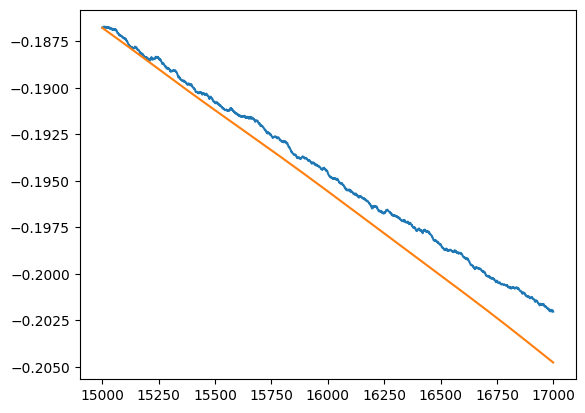

In [188]:
plt.plot(time_values_test, test_w_sgd[0:2000, 3172])
plt.plot(time_values_test, edmd_sgd_values[3172 + 600].iloc[time_values_test])

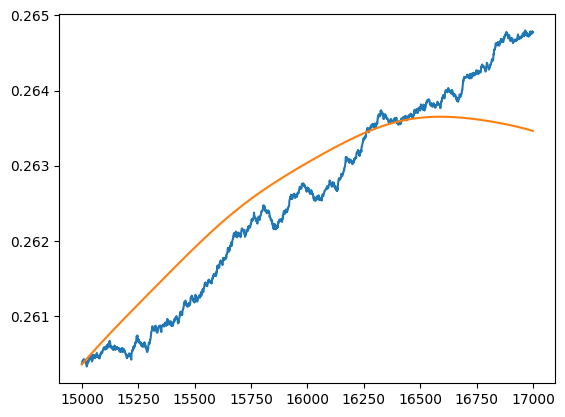

In [189]:
plt.plot(time_values_test, test_w_sgd[0:2000, 3171])
plt.plot(time_values_test, edmd_sgd_values[3171 + 600].iloc[time_values_test])

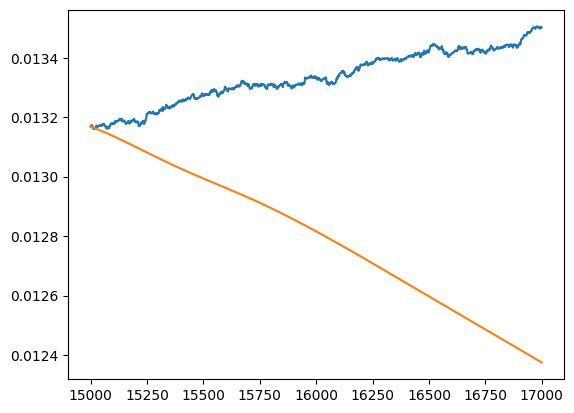

In [190]:
plt.plot(time_values_test, test_w_sgd[0:2000, 2100])
plt.plot(time_values_test, edmd_sgd_values[2100 + 600].iloc[time_values_test])

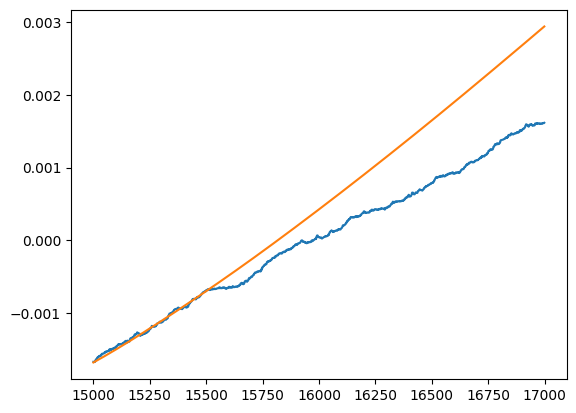

In [191]:
plt.plot(time_values_test, test_w_sgd[0:2000, 3000])
plt.plot(time_values_test, edmd_sgd_values[3000 + 600].iloc[time_values_test])

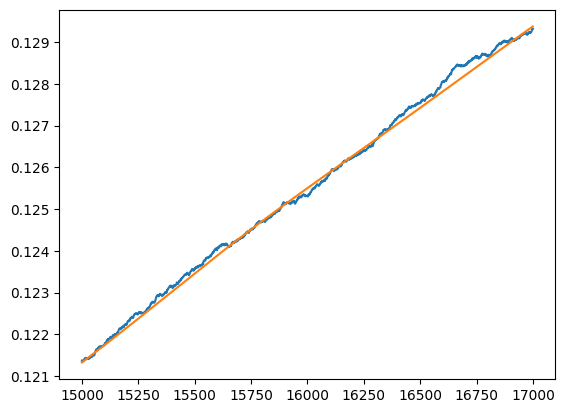

In [192]:
plt.plot(time_values_test, test_w_sgd[0:2000, 50])
plt.plot(time_values_test, edmd_sgd_values[50 + 600].iloc[time_values_test])

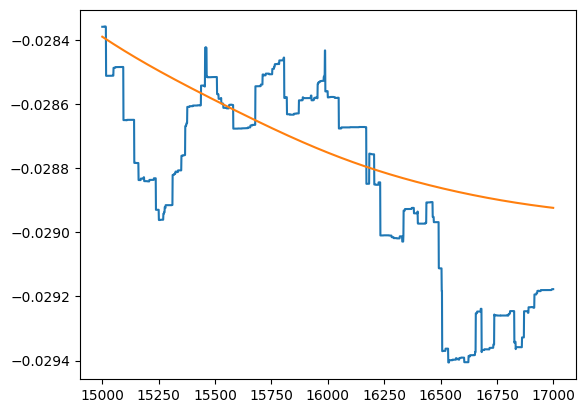

In [122]:
plt.plot(time_values_test, test_w_sgd[0:2000, 1])
plt.plot(time_values_test, edmd_sgd_values[1 + 600].iloc[time_values_test])

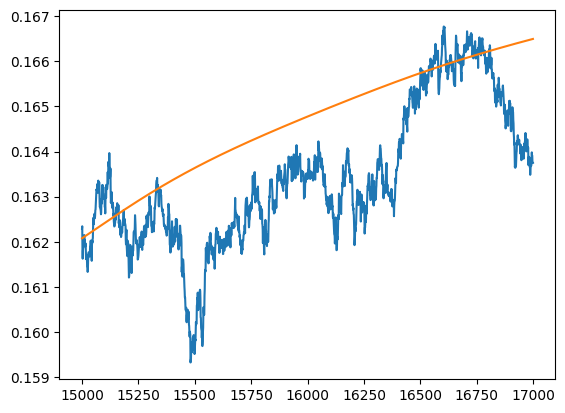

In [123]:
plt.plot(time_values_test, test_w_sgd[0:2000, 100])
plt.plot(time_values_test, edmd_sgd_values[100 + 600].iloc[time_values_test])

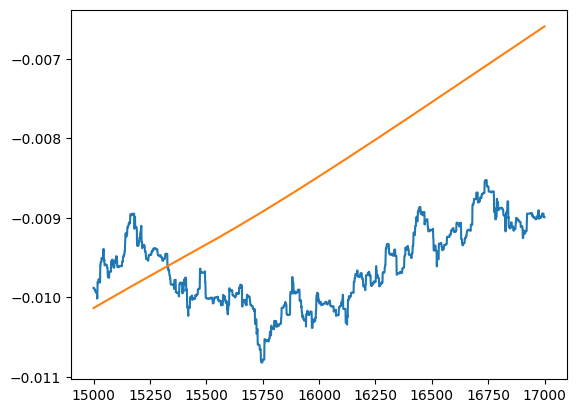

In [124]:
plt.plot(time_values_test, test_w_sgd[0:2000, 1050])
plt.plot(time_values_test, edmd_sgd_values[1050 + 600].iloc[time_values_test])

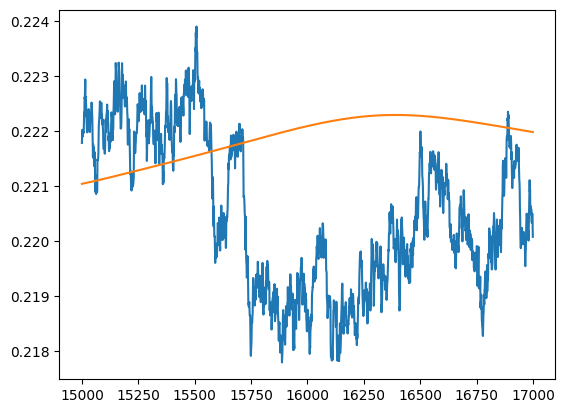

In [125]:
plt.plot(time_values_test, test_w_sgd[0:2000, 1060])
plt.plot(time_values_test, edmd_sgd_values[1060 + 600].iloc[time_values_test])

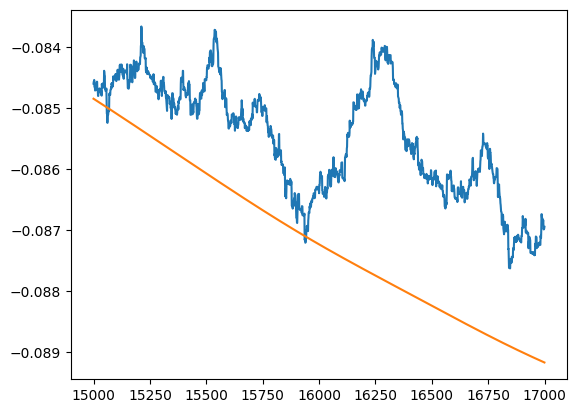

In [126]:
plt.plot(time_values_test, test_w_sgd[0:2000, 1048])
plt.plot(time_values_test, edmd_sgd_values[1048 + 600].iloc[time_values_test])

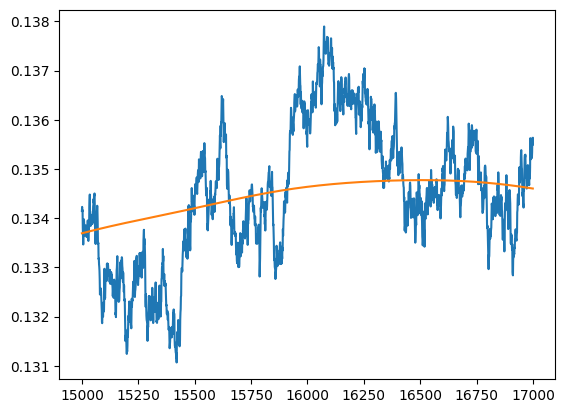

In [127]:
plt.plot(time_values_test, test_w_sgd[0:2000, 2048])
plt.plot(time_values_test, edmd_sgd_values[2048 + 600].iloc[time_values_test])

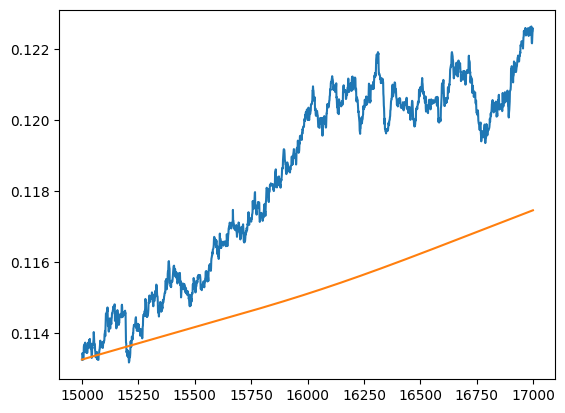

In [128]:
plt.plot(time_values_test, test_w_sgd[0:2000, 10])
plt.plot(time_values_test, edmd_sgd_values[10 + 600].iloc[time_values_test])

- reduce r

### Apply EDMD to SGD with momentum weights

In [33]:
w = np.load("w_sgd_mom_nn.pkl.npy")

In [34]:
w

array([[-0.00326786, -0.02545078, -0.00450276, ...,  0.02462918,
        -0.05136228,  0.30388865],
       [-0.00326786, -0.02545078, -0.00450257, ...,  0.02458238,
        -0.05142114,  0.30384699],
       [-0.00326786, -0.02545078, -0.00450241, ...,  0.02455724,
        -0.05151875,  0.30379939],
       ...,
       [-0.0067423 , -0.02812907,  0.00727474, ...,  0.2881895 ,
        -0.63858449,  0.31377655],
       [-0.00674227, -0.02812763,  0.00728034, ...,  0.28812373,
        -0.63859469,  0.31384367],
       [-0.00674225, -0.02812633,  0.00728539, ...,  0.2880775 ,
        -0.63858688,  0.31390977]])

In [35]:
w.shape

(15000, 3174)

In [37]:
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = KMeans(600, verbose=1, init='k-means++', n_init=1, random_state=11)
kmeans.fit(w)
#def get_centers_knn():

identified_clusters = kmeans.fit_predict(w)
identified_clusters
unique, counts = np.unique(identified_clusters, return_counts=True)

centers = kmeans.cluster_centers_
centers

Initialization complete
Iteration 0, inertia 3.387122622699581.
Iteration 1, inertia 2.606960873901725.
Iteration 2, inertia 2.5448583424458158.
Iteration 3, inertia 2.5136093148271357.
Iteration 4, inertia 2.4947280788822015.
Iteration 5, inertia 2.4820643170304946.
Iteration 6, inertia 2.472655051865098.
Iteration 7, inertia 2.4663142499115147.
Iteration 8, inertia 2.461371123949446.
Iteration 9, inertia 2.4577759302070805.
Iteration 10, inertia 2.4551276167167813.
Iteration 11, inertia 2.4531879370324283.
Iteration 12, inertia 2.4517638971002342.
Iteration 13, inertia 2.4507540848734806.
Iteration 14, inertia 2.4499788468389045.
Iteration 15, inertia 2.4490635167974264.
Iteration 16, inertia 2.4484202668342405.
Iteration 17, inertia 2.4477608957013355.
Iteration 18, inertia 2.4471399888390373.
Iteration 19, inertia 2.446595016237617.
Iteration 20, inertia 2.44605031050682.
Iteration 21, inertia 2.445578939990065.
Iteration 22, inertia 2.4451742382042068.
Iteration 23, inertia 2.4447

array([[-0.00534701, -0.02635365,  0.00457208, ...,  0.29999691,
        -0.5248496 ,  0.28717419],
       [-0.00327035, -0.02460911, -0.00233599, ...,  0.26690542,
        -0.19530802,  0.27403563],
       [-0.00325711, -0.02543936, -0.00448715, ...,  0.03864148,
        -0.04682562,  0.26478827],
       ...,
       [-0.00398034, -0.02462055,  0.00145057, ...,  0.29846901,
        -0.3738441 ,  0.27230624],
       [-0.0063003 , -0.02754615,  0.00657259, ...,  0.29405249,
        -0.59952986,  0.30393225],
       [-0.00455471, -0.02543314,  0.00252447, ...,  0.30432609,
        -0.45356487,  0.27832881]])

In [38]:
w_t_transformed = np.apply_along_axis(lambda x: rbf_thin_plate(centers,x), 1, w)
w_t_transformed.shape

(15000, 600)

In [39]:
w_t_transformed.shape

(15000, 600)

In [40]:
w_t_combined = np.hstack((w_t_transformed, w))
w_t_combined.shape

(15000, 3774)

In [41]:
np.save("w_t_combined_sgd_mom.pkl", w_t_combined)

In [42]:
w_t_combined = np.load("w_t_combined_sgd_mom.pkl.npy")
w_t_combined.shape

(15000, 3774)

In [43]:
from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis, TSCIdentity, TSCApplyLambdas, TSCFeaturePreprocess
from datafold.pcfold import GaussianKernel, TSCDataFrame

In [44]:
w_tsc = TSCDataFrame.from_single_timeseries(pd.DataFrame(w_t_combined))
w_tsc.shape

(15000, 3774)

In [45]:
print(f"time delta: {w_tsc.delta_time}")
print(f"#time series: {w_tsc.n_timeseries}")
print(f"#time steps per time series: {w_tsc.n_timesteps}")
print(f"(n_samples, n_features): {w_tsc.shape}")
print(f"time interval {w_tsc.time_interval()}")
print(f"Same time values: {w_tsc.is_same_time_values()}")

time delta: 1
#time series: 1
#time steps per time series: 15000
(n_samples, n_features): (15000, 3774)
time interval (0, 14999)
Same time values: True


In [46]:
dict_step = [
    (
        "identity",
        TSCIdentity()
    )
]

edmd_sgd_mom = EDMD(dict_steps=dict_step, include_id_state=False).fit(
    X=w_tsc
)  # Note that the "extended" part is in the transformations


/Users/saksham/miniconda3/envs/code/lib/python3.8/site-packages/datafold/dynfold/dmd.py:1187: UserWarning: Shift matrix (shape=(3774, 3774)) has not full rank (=344), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [47]:
edmd_sgd_mom

EDMD(dict_steps=[('identity', TSCIdentity())], dmd_model=DMDFull(),
     include_id_state=False)

In [48]:
import pickle
with open('edmd_sgd_mom.pkl', 'wb') as outp:
    pickle.dump(edmd_sgd_mom, outp, pickle.HIGHEST_PROTOCOL)


In [125]:
with open('edmd_sgd_mom.pkl', 'rb') as inp:
    edmd_sgd_mom = pickle.load(inp)

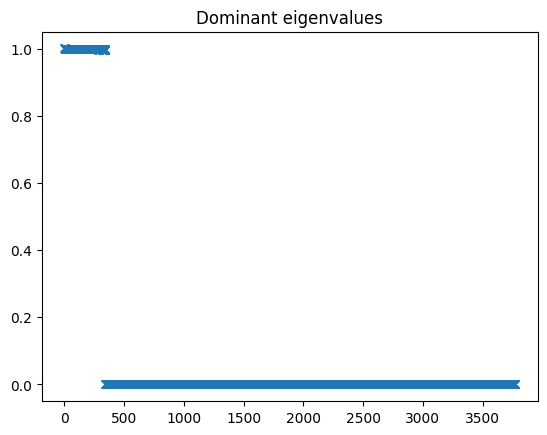

In [49]:
plt.plot(np.abs(edmd_sgd_mom.koopman_eigenvalues), 'x')
plt.title('Dominant eigenvalues');

In [162]:
sum(np.abs(edmd_sgd.koopman_eigenvalues) > 0.9)

182

In [229]:
sum(np.abs(edmd_sgd_mom.koopman_eigenvalues) > 0.9)

339

In [160]:
sum(np.abs(edmd_adam.koopman_eigenvalues) > 0.8)

574

In [161]:
sum(np.abs(edmd_adam.koopman_eigenvalues) > 0.9)

574

In [163]:
np.max(np.abs(edmd_adam.koopman_eigenvalues))

1.0002418186594486

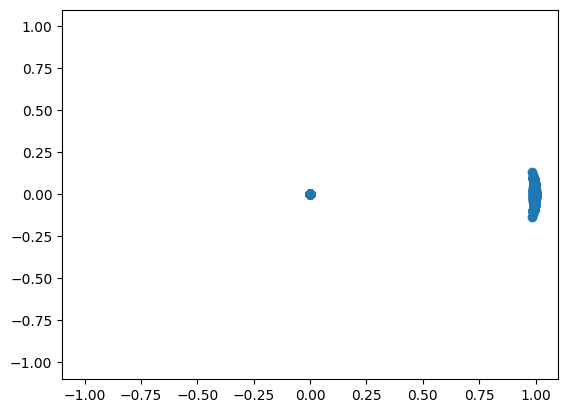

In [164]:
import matplotlib.pyplot as plt

ev = np.array(edmd_adam.koopman_eigenvalues.array)
fig,ax = plt.subplots()
plt.xlim((-1.1,1.1))
plt.ylim((-1.1,1.1))

ax.scatter(ev.real, ev.imag)

In [165]:
# predict a 1000 time steps more than the train dataset time steps
time_values_all = np.arange(0, w_tsc.shape[0] + 4000)
time_values_train = np.arange(0, w_tsc.shape[0])
time_values_test = np.arange(w_tsc.shape[0], w_tsc.shape[0] + 4000)
time_values_all.shape, time_values_train.shape, time_values_test.shape

((19000,), (15000,), (4000,))

In [166]:
edmd_sgd_values = edmd_sgd.predict(w_tsc.initial_states(), time_values=time_values_all)

len_koopman_matrix = len(edmd_sgd.named_steps["dmd"].eigenvectors_right_)
print(f"shape of Koopman matrix: {len_koopman_matrix} x {len_koopman_matrix}")
#edmd_rbf.transform(tsc_data)

shape of Koopman matrix: 3774 x 3774


In [37]:
edmd_sgd_values.shape

(19000, 3474)

In [167]:
edmd_sgd_values[1001]

feature       1001
ID time           
0  0     -0.010576
   1     -0.010567
   2     -0.010567
   3     -0.010566
   4     -0.010565
...            ...
   18995  0.029837
   18996  0.029838
   18997  0.029840
   18998  0.029841
   18999  0.029842

[19000 rows x 1 columns]

In [168]:
edmd_sgd_values

feature       0          1          2          3          4          5     \
ID time                                                                     
0  0      7.500016   0.253530  19.674684  -0.154644   2.627817  12.817789   
   1      7.498406   0.253147  19.672282  -0.154489   2.626829  12.815755   
   2      7.496801   0.252759  19.669878  -0.154355   2.625826  12.813733   
   3      7.495193   0.252369  19.667467  -0.154225   2.624821  12.811705   
   4      7.493583   0.251976  19.665048  -0.154097   2.623814  12.809673   
...            ...        ...        ...        ...        ...        ...   
   18995  4.243321  19.161937   0.553916  29.536990  10.426713   1.655655   
   18996  4.244189  19.163500   0.554539  29.539045  10.427849   1.656360   
   18997  4.245057  19.165064   0.555161  29.541099  10.428984   1.657065   
   18998  4.245926  19.166627   0.555784  29.543154  10.430120   1.657771   
   18999  4.246794  19.168190   0.556407  29.545208  10.431255   1.658476   

feature        6          7         8          9     ...      3764      3765  \
ID time                                              ...                       
0  0      21.941024  -0.136742  4.803709   0.990254  ... -0.276224  0.375153   
   1      21.938519  -0.136823  4.802404   0.989612  ... -0.276083  0.375203   
   2      21.936014  -0.136927  4.801089   0.988960  ... -0.276068  0.375172   
   3      21.933500  -0.137034  4.799771   0.988306  ... -0.276053  0.375141   
   4      21.930977  -0.137144  4.798451   0.987649  ... -0.276037  0.375110   
...             ...        ...       ...        ...  ...       ...       ...   
   18995   0.455041  24.438190  6.874650  15.114424  ... -0.359229  0.217307   
   18996   0.455648  24.440044  6.875645  15.115744  ... -0.359209  0.217308   
   18997   0.456256  24.441898  6.876640  15.117064  ... -0.359189  0.217309   
   18998   0.456864  24.443752  6.877635  15.118383  ... -0.359169  0.217310   
   18999   0.457472  24.445606  6.878631  15.119703  ... -0.359149  0.217311   

feature       3766      3767      3768      3769      3770      3771  \
ID time                                                                
0  0     -0.370109 -0.279772 -0.147659  0.173530  0.356168  0.024629   
   1     -0.370143 -0.279604 -0.147599  0.173318  0.356197  0.024702   
   2     -0.370113 -0.279570 -0.147580  0.173327  0.356152  0.024710   
   3     -0.370083 -0.279535 -0.147561  0.173334  0.356106  0.024718   
   4     -0.370053 -0.279500 -0.147543  0.173341  0.356060  0.024726   
...            ...       ...       ...       ...       ...       ...   
   18995 -0.377333 -0.072432 -0.079498  0.391310  0.053839  0.253883   
   18996 -0.377331 -0.072445 -0.079494  0.391299  0.053848  0.253874   
   18997 -0.377329 -0.072457 -0.079490  0.391288  0.053856  0.253865   
   18998 -0.377326 -0.072470 -0.079486  0.391278  0.053864  0.253856   
   18999 -0.377324 -0.072483 -0.079482  0.391267  0.053872  0.253846   

feature       3772      3773  
ID time                       
0  0     -0.051362  0.303889  
   1     -0.051549  0.303801  
   2     -0.051551  0.303765  
   3     -0.051552  0.303729  
   4     -0.051553  0.303693  
...            ...       ...  
   18995 -0.223614  0.291375  
   18996 -0.223622  0.291374  
   18997 -0.223629  0.291374  
   18998 -0.223636  0.291373  
   18999 -0.223643  0.291373  

[19000 rows x 3774 columns]

In [169]:
edmd_sgd_values.to_pickle("edmd_sgd_predict_600.pkl")

In [174]:
edmd_sgd.koopman_eigenvalues.shape

(3774,)

In [175]:
import matplotlib.pyplot as plt

In [176]:
edmd_sgd_values[1001].iloc[time_values_train]

feature       1001
ID time           
0  0     -0.010576
   1     -0.010567
   2     -0.010567
   3     -0.010566
   4     -0.010565
...            ...
   14995  0.023594
   14996  0.023596
   14997  0.023597
   14998  0.023599
   14999  0.023600

[15000 rows x 1 columns]

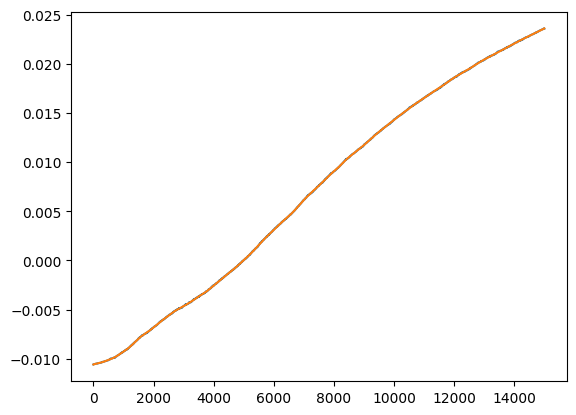

In [177]:
plt.plot(time_values_train, w_t_combined[:,1001])
plt.plot(time_values_train, edmd_sgd_values[1001].iloc[time_values_train])

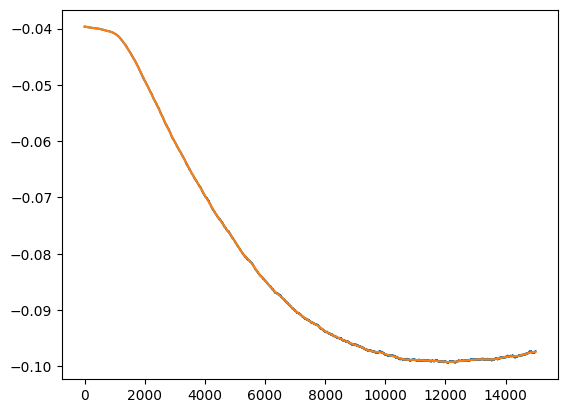

In [178]:
plt.plot(time_values_train, w_t_combined[:,3000])
plt.plot(time_values_train, edmd_sgd_values[3000].iloc[time_values_train])

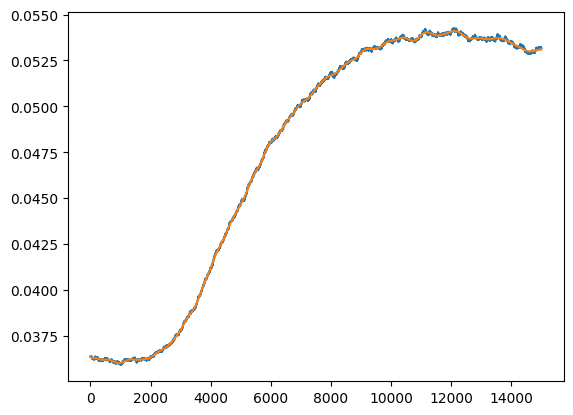

In [179]:
plt.plot(time_values_train, w_t_combined[:,2500])
plt.plot(time_values_train, edmd_sgd_values[2500].iloc[time_values_train])

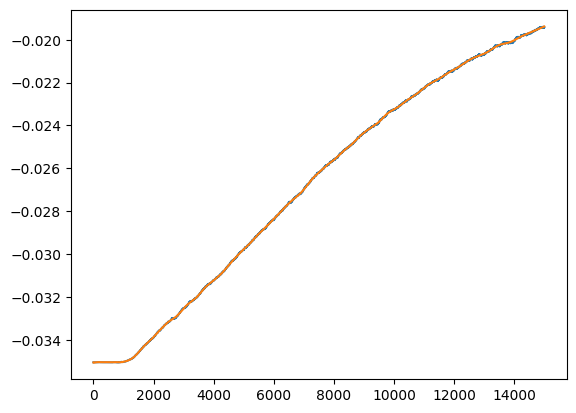

In [180]:
plt.plot(time_values_train, w_t_combined[:,3200])
plt.plot(time_values_train, edmd_sgd_values[3200].iloc[time_values_train])

In [181]:
edmd_sgd.koopman_modes

,evec0,evec1,evec2,evec3,evec4,evec5,evec6,evec7,evec8,evec9,...,evec3764,evec3765,evec3766,evec3767,evec3768,evec3769,evec3770,evec3771,evec3772,evec3773
feature,,,,,,,,,,,,,,,,,,,,,
0,0.015197-0.014466j,0.015197+0.014466j,0.001232-0.013896j,0.001232+0.013896j,0.054243+0.026638j,0.054243-0.026638j,0.028326-0.040208j,0.028326+0.040208j,0.000864+0.032827j,0.000864-0.032827j,...,-0.003278-0.007110j,-0.003278+0.007110j,-0.015341+0.000000j,-0.001605-0.001614j,-0.001605+0.001614j,-0.006003-0.003481j,-0.006003+0.003481j,-0.013209-0.002690j,-0.013209+0.002690j,-0.010993+0.000000j
1,0.049896-0.011707j,0.049896+0.011707j,-0.027440-0.002768j,-0.027440+0.002768j,-0.001607-0.022780j,-0.001607+0.022780j,-0.033115-0.016662j,-0.033115+0.016662j,-0.050169+0.008443j,-0.050169-0.008443j,...,-0.000314-0.003831j,-0.000314+0.003831j,0.002582+0.000000j,-0.045239+0.004148j,-0.045239-0.004148j,0.005323-0.016646j,0.005323+0.016646j,0.008880-0.003773j,0.008880+0.003773j,-0.008970+0.000000j
2,0.007108-0.016341j,0.007108+0.016341j,-0.062001-0.018105j,-0.062001+0.018105j,0.029793-0.002008j,0.029793+0.002008j,0.027549-0.019208j,0.027549+0.019208j,0.050519-0.005946j,0.050519+0.005946j,...,0.004399+0.024742j,0.004399-0.024742j,0.004456+0.000000j,-0.033481+0.003096j,-0.033481-0.003096j,-0.027092-0.024912j,-0.027092+0.024912j,-0.012271-0.004931j,-0.012271+0.004931j,-0.017576+0.000000j
3,0.071281-0.004479j,0.071281+0.004479j,-0.028475-0.032873j,-0.028475+0.032873j,0.016501+0.013011j,0.016501-0.013011j,0.001547+0.005616j,0.001547-0.005616j,-0.006457+0.001769j,-0.006457-0.001769j,...,0.014884+0.005495j,0.014884-0.005495j,0.043029+0.000000j,-0.007098-0.010361j,-0.007098+0.010361j,0.063873-0.004779j,0.063873+0.004779j,0.050269+0.013117j,0.050269-0.013117j,-0.001482+0.000000j
4,0.029961-0.014712j,0.029961+0.014712j,-0.005614+0.009256j,-0.005614-0.009256j,-0.021242+0.019897j,-0.021242-0.019897j,0.027354+0.048475j,0.027354-0.048475j,0.058000-0.008656j,0.058000+0.008656j,...,-0.002556+0.006296j,-0.002556-0.006296j,-0.004616+0.000000j,0.018807-0.028149j,0.018807+0.028149j,-0.015162-0.036143j,-0.015162+0.036143j,-0.010222-0.027597j,-0.010222+0.027597j,-0.030422+0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,0.000559+0.000783j,0.000559-0.000783j,0.000782+0.000181j,0.000782-0.000181j,-0.000602+0.000071j,-0.000602-0.000071j,-0.000297-0.000290j,-0.000297+0.000290j,-0.000511-0.000629j,-0.000511+0.000629j,...,0.012914-0.011451j,0.012914+0.011451j,-0.001955+0.000000j,-0.014311-0.036585j,-0.014311+0.036585j,-0.015223-0.017034j,-0.015223+0.017034j,-0.019708-0.004062j,-0.019708+0.004062j,-0.012923+0.000000j
3770,0.000167-0.000165j,0.000167+0.000165j,-0.000403-0.000332j,-0.000403+0.000332j,0.000420+0.000032j,0.000420-0.000032j,-0.000085-0.000306j,-0.000085+0.000306j,-0.000692-0.000172j,-0.000692+0.000172j,...,-0.035040-0.009387j,-0.035040+0.009387j,-0.042918+0.000000j,0.021978-0.017794j,0.021978+0.017794j,-0.007341-0.038079j,-0.007341+0.038079j,0.002827-0.029188j,0.002827+0.029188j,-0.021488+0.000000j
3771,0.000336+0.000587j,0.000336-0.000587j,0.000655+0.000018j,0.000655-0.000018j,-0.000543+0.000237j,-0.000543-0.000237j,0.000049+0.000102j,0.000049-0.000102j,0.000430-0.000258j,0.000430+0.000258j,...,-0.006990-0.016225j,-0.006990+0.016225j,-0.015758+0.000000j,0.002488+0.001846j,0.002488-0.001846j,0.016433-0.003542j,0.016433+0.003542j,0.006667+0.002773j,0.006667-0.002773j,-0.015318+0.000000j


In [182]:
edmd_sgd.koopman_modes.describe()

,evec0,evec1,evec2,evec3,evec4,evec5,evec6,evec7,evec8,evec9,...,evec3764,evec3765,evec3766,evec3767,evec3768,evec3769,evec3770,evec3771,evec3772,evec3773
count,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,...,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j,3774.0000+0.0000j
mean,0.004814-0.002015j,0.004814+0.002015j,-0.004285-0.002247j,-0.004285+0.002247j,0.003514+0.000154j,0.003514-0.000154j,0.002463+0.000289j,0.002463-0.000289j,0.001598+0.000117j,0.001598-0.000117j,...,-0.000050-0.000037j,-0.000050+0.000037j,-0.000158+0.000000j,-0.000107-0.000104j,-0.000107+0.000104j,-0.000129+0.000020j,-0.000129-0.000020j,-0.000145-0.000050j,-0.000145+0.000050j,-0.000102+0.000000j
std,0.015421+0.000000j,0.015421+0.000000j,0.015544+0.000000j,0.015544+0.000000j,0.015896+0.000000j,0.015896+0.000000j,0.016090+0.000000j,0.016090+0.000000j,0.016201+0.000000j,0.016201+0.000000j,...,0.016280+0.000000j,0.016280+0.000000j,0.016279+0.000000j,0.016279+0.000000j,0.016279+0.000000j,0.016280+0.000000j,0.016280+0.000000j,0.016279+0.000000j,0.016279+0.000000j,0.016280+0.000000j
min,-0.001674-0.000988j,-0.001674+0.000988j,-0.068399-0.000000j,-0.068399+0.000000j,-0.026848+0.001246j,-0.026848-0.001246j,-0.040360+0.004107j,-0.040360-0.004107j,-0.050653+0.002261j,-0.050653-0.002261j,...,-0.123196-0.000000j,-0.123196+0.000000j,-0.207021+0.000000j,-0.112156-0.068684j,-0.112156+0.068684j,-0.140283-0.000000j,-0.140283+0.000000j,-0.104079-0.021944j,-0.104079+0.021944j,-0.175909+0.000000j
25%,-0.000024+0.000143j,-0.000024-0.000143j,-0.000061+0.000009j,-0.000061-0.000009j,-0.000066+0.000118j,-0.000066-0.000118j,-0.000123-0.000049j,-0.000123+0.000049j,-0.000200-0.000218j,-0.000200+0.000218j,...,-0.005354+0.002879j,-0.005354-0.002879j,-0.006776+0.000000j,-0.005095-0.001165j,-0.005095+0.001165j,-0.005374+0.001267j,-0.005374-0.001267j,-0.005559-0.000676j,-0.005559+0.000676j,-0.006112+0.000000j
50%,0.000049+0.000022j,0.000049-0.000022j,0.000000+0.000051j,0.000000-0.000051j,0.000012+0.000017j,0.000012-0.000017j,0.000005+0.000029j,0.000005-0.000029j,0.000001-0.000031j,0.000001+0.000031j,...,-0.000137-0.002225j,-0.000137+0.002225j,-0.000075+0.000000j,-0.000045-0.000924j,-0.000045+0.000924j,-0.000022-0.000745j,-0.000022+0.000745j,-0.000126-0.001283j,-0.000126+0.001283j,-0.000136+0.000000j
75%,0.000193+0.000241j,0.000193-0.000241j,0.000054+0.000106j,0.000054-0.000106j,0.000109+0.000018j,0.000109-0.000018j,0.000142-0.000015j,0.000142+0.000015j,0.000184+0.000144j,0.000184-0.000144j,...,0.005339-0.006658j,0.005339+0.006658j,0.006666+0.000000j,0.004841-0.002877j,0.004841+0.002877j,0.005026+0.004500j,0.005026-0.004500j,0.005061-0.005026j,0.005061+0.005026j,0.005918+0.000000j
max,0.080594+0.000000j,0.080594-0.000000j,0.003357-0.004603j,0.003357+0.004603j,0.065579-0.000000j,0.065579+0.000000j,0.067390+0.000000j,0.067390-0.000000j,0.058984-0.000000j,0.058984+0.000000j,...,0.104994+0.019208j,0.104994-0.019208j,0.170120+0.000000j,0.141577+0.000000j,0.141577-0.000000j,0.118878+0.002383j,0.118878-0.002383j,0.191037+0.000000j,0.191037-0.000000j,0.255777+0.000000j


### predict beyond time values in fit dataset

In [183]:
time_values_test = np.arange(w_tsc.shape[0], w_tsc.shape[0] + 2000)


In [184]:
time_values_test.shape

(2000,)

In [185]:
test_w_sgd = np.load("test_w_sgd_nn.pkl.npy")
test_w_sgd.shape

(4551, 3174)

In [186]:
edmd_sgd_values.shape

(19000, 3774)

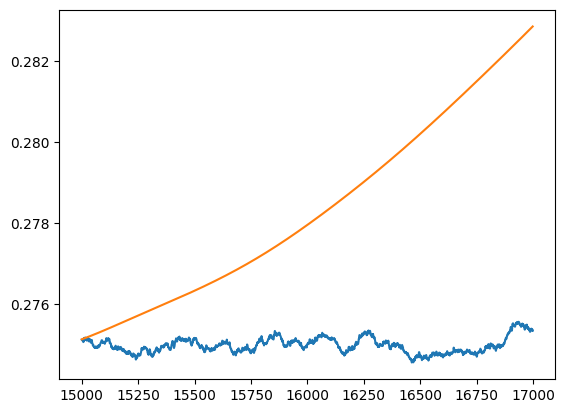

In [187]:
plt.plot(time_values_test, test_w_sgd[0:2000, 3173])
plt.plot(time_values_test, edmd_sgd_values[3173 + 600].iloc[time_values_test])

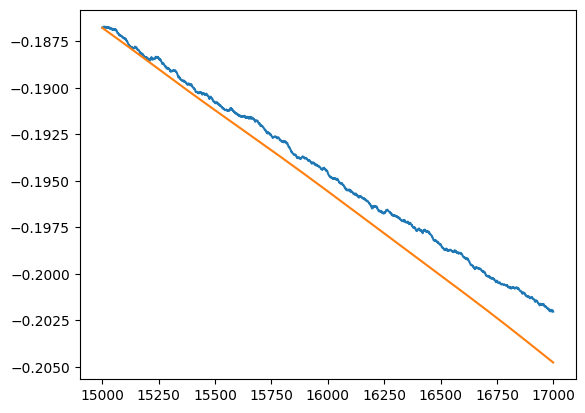

In [188]:
plt.plot(time_values_test, test_w_sgd[0:2000, 3172])
plt.plot(time_values_test, edmd_sgd_values[3172 + 600].iloc[time_values_test])

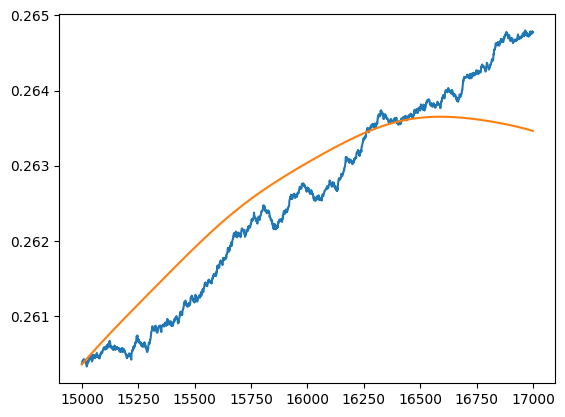

In [189]:
plt.plot(time_values_test, test_w_sgd[0:2000, 3171])
plt.plot(time_values_test, edmd_sgd_values[3171 + 600].iloc[time_values_test])

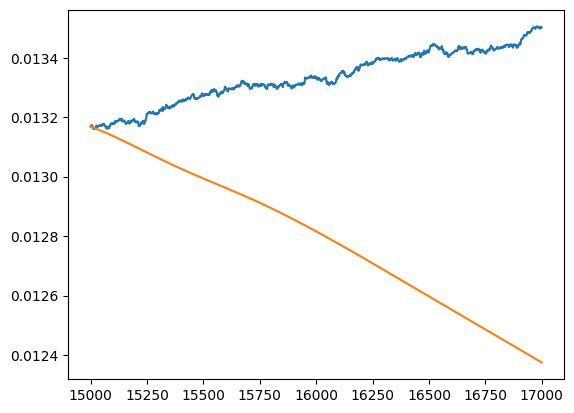

In [190]:
plt.plot(time_values_test, test_w_sgd[0:2000, 2100])
plt.plot(time_values_test, edmd_sgd_values[2100 + 600].iloc[time_values_test])

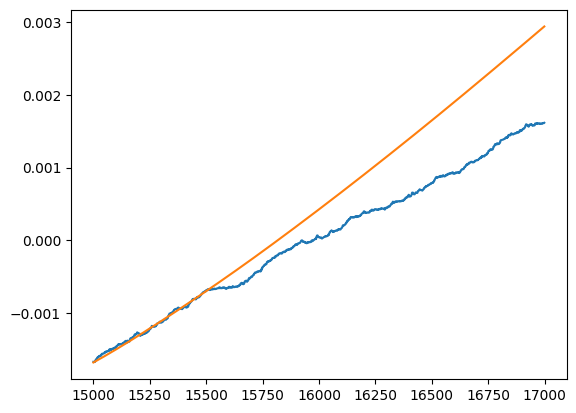

In [191]:
plt.plot(time_values_test, test_w_sgd[0:2000, 3000])
plt.plot(time_values_test, edmd_sgd_values[3000 + 600].iloc[time_values_test])

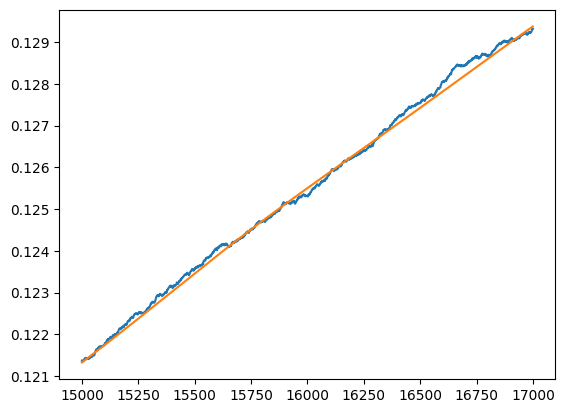

In [192]:
plt.plot(time_values_test, test_w_sgd[0:2000, 50])
plt.plot(time_values_test, edmd_sgd_values[50 + 600].iloc[time_values_test])

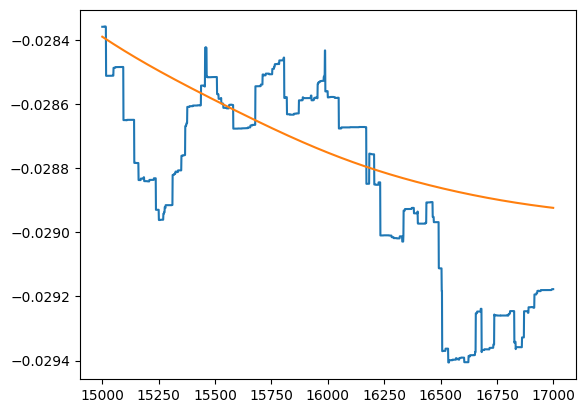

In [122]:
plt.plot(time_values_test, test_w_sgd[0:2000, 1])
plt.plot(time_values_test, edmd_sgd_values[1 + 600].iloc[time_values_test])

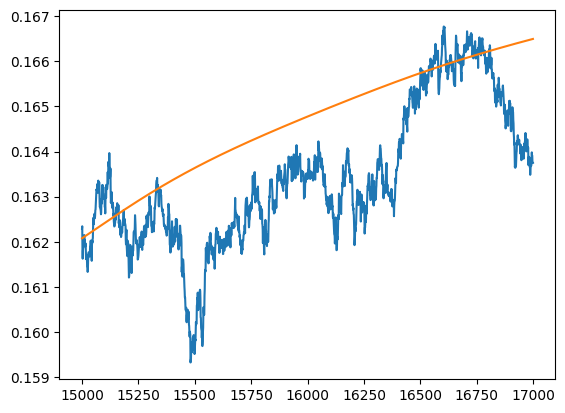

In [123]:
plt.plot(time_values_test, test_w_sgd[0:2000, 100])
plt.plot(time_values_test, edmd_sgd_values[100 + 600].iloc[time_values_test])

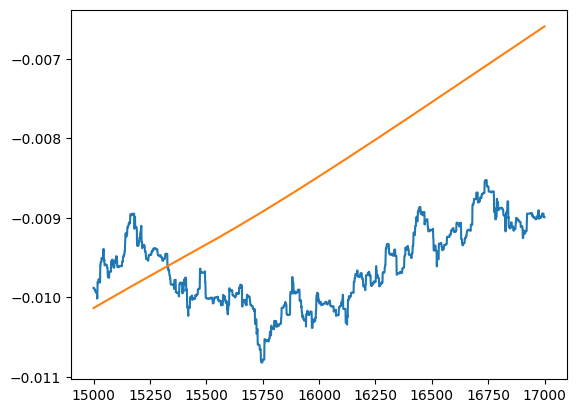

In [124]:
plt.plot(time_values_test, test_w_sgd[0:2000, 1050])
plt.plot(time_values_test, edmd_sgd_values[1050 + 600].iloc[time_values_test])

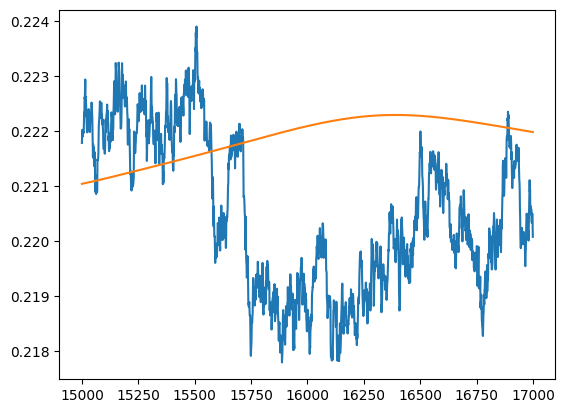

In [125]:
plt.plot(time_values_test, test_w_sgd[0:2000, 1060])
plt.plot(time_values_test, edmd_sgd_values[1060 + 600].iloc[time_values_test])

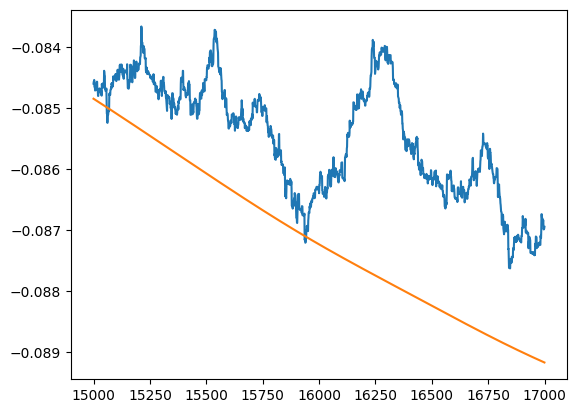

In [126]:
plt.plot(time_values_test, test_w_sgd[0:2000, 1048])
plt.plot(time_values_test, edmd_sgd_values[1048 + 600].iloc[time_values_test])

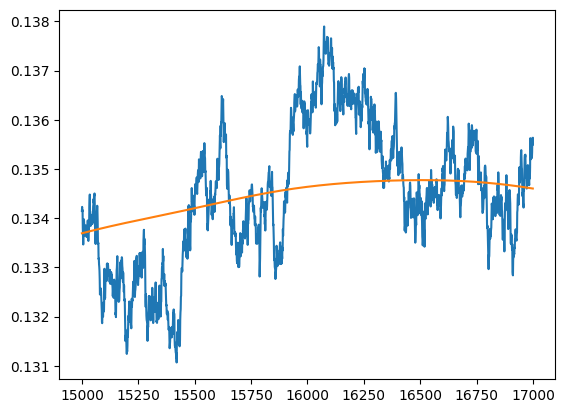

In [127]:
plt.plot(time_values_test, test_w_sgd[0:2000, 2048])
plt.plot(time_values_test, edmd_sgd_values[2048 + 600].iloc[time_values_test])

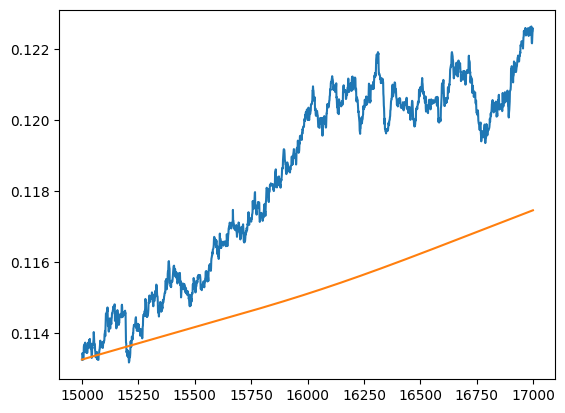

In [128]:
plt.plot(time_values_test, test_w_sgd[0:2000, 10])
plt.plot(time_values_test, edmd_sgd_values[10 + 600].iloc[time_values_test])

- reduce r